### Encoder and Decoder

In [26]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    
    def __init__(self, im_chan=1, output_chan=32, hidden_dim=16):
        
        super(Encoder, self).__init__()
        self.z_dim = output_chan
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, output_chan * 2, final_layer=True)
        )
        
    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        
        if not final_layer:
            
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )
        
    def forward(self, image):
        
        disc_pred = self.disc(image)
        encoding = disc_pred.view(len(disc_pred), -1)
        
        # The stddev output is treated as the log of the variance of the normal 
        # distribution by convention and for numerical stability
        return encoding[:, :self.z_dim], encoding[:, :self.z_dim].exp()
    
class Decoder(nn.Module):
    
    def __init__(self, z_dim=32, im_chan=1, hidden_dim=64):
        super(Decoder, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )
        
    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a Decoder block of the VAE, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation
        Parameters:
        input_channels: how many channels the input feature representation has
        output_channels: how many channels the output feature representation should have
        kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
        stride: the stride of the convolution
        final_layer: whether we're on the final layer (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Sigmoid(),
            )
        
    def forward(self, noise):
        '''
        Function for completing a forward pass of the Decoder: Given a noise vector, 
        returns a generated image.
        Parameters:
        noise: a noise tensor with dimensions (batch_size, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

### Reparameterization Trick

In [27]:
from torch.distributions.normal import Normal

class VAE(nn.Module):
    
    def __init__(self, z_dim=32, im_chan=1, hidden_dim=64):
        
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.encode = Encoder(im_chan, z_dim)
        self.decode = Decoder(z_dim, im_chan)

    def forward(self, images):
        
        q_mean, q_stddev = self.encode(images)
        q_dist = Normal(q_mean, q_stddev)
        z_sample = q_dist.rsample()
        decoding = self.decode(z_sample)
        return decoding, q_dist

### Reconstruction Loss

For MNIST, you can treat each grayscale prediction as a binary random variable (also known as a Bernoulli distribution) with the value between 0 and 1 of a pixel corresponding to the output brightness, so you can use the binary cross entropy loss between the real input image and the generated image in order to represent the reconstruction loss term.

In [28]:
reconstruction_loss = nn.BCELoss(reduction='sum')

### KL Divergence

In [29]:
from torch.distributions.kl import kl_divergence

def kl_divergence_loss(q_dist):
    
    return kl_divergence(
        q_dist, Normal(torch.zeros_like(q_dist.mean), torch.ones_like(q_dist.stddev))
    ).sum(-1)

### Training a VAE

In [30]:
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
])
mnist_dataset = datasets.MNIST('dataset/', train=True, transform=transform)
train_dataloader = DataLoader(mnist_dataset, shuffle=True, batch_size=1024)

Epoch 0


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  8.00it/s]


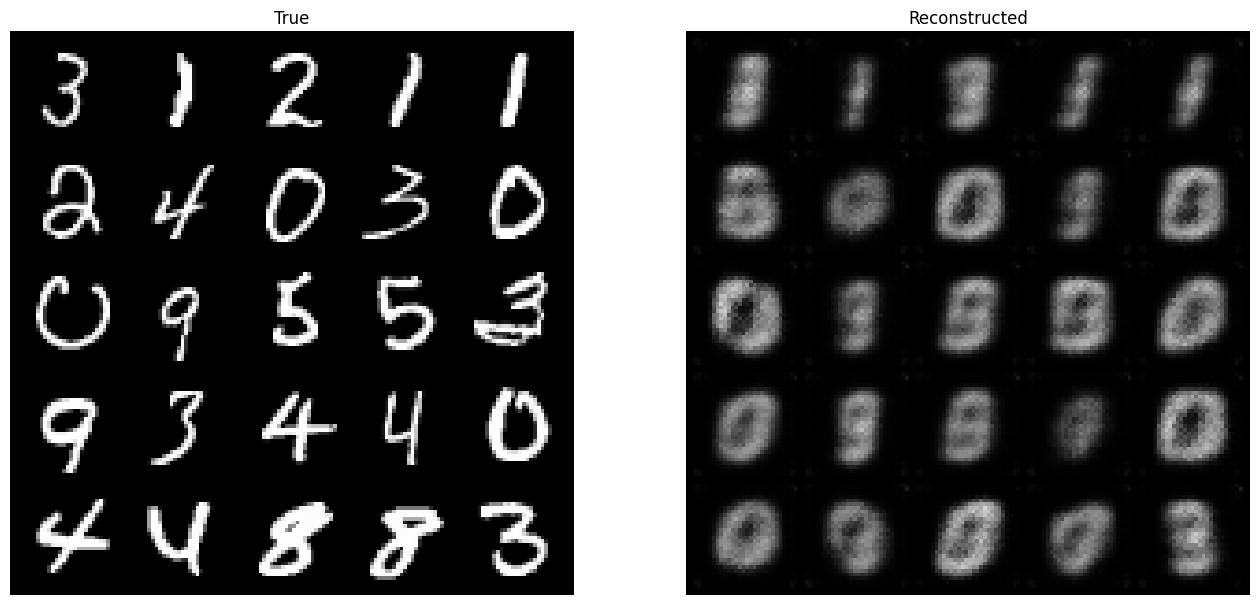

Epoch 1


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  8.03it/s]


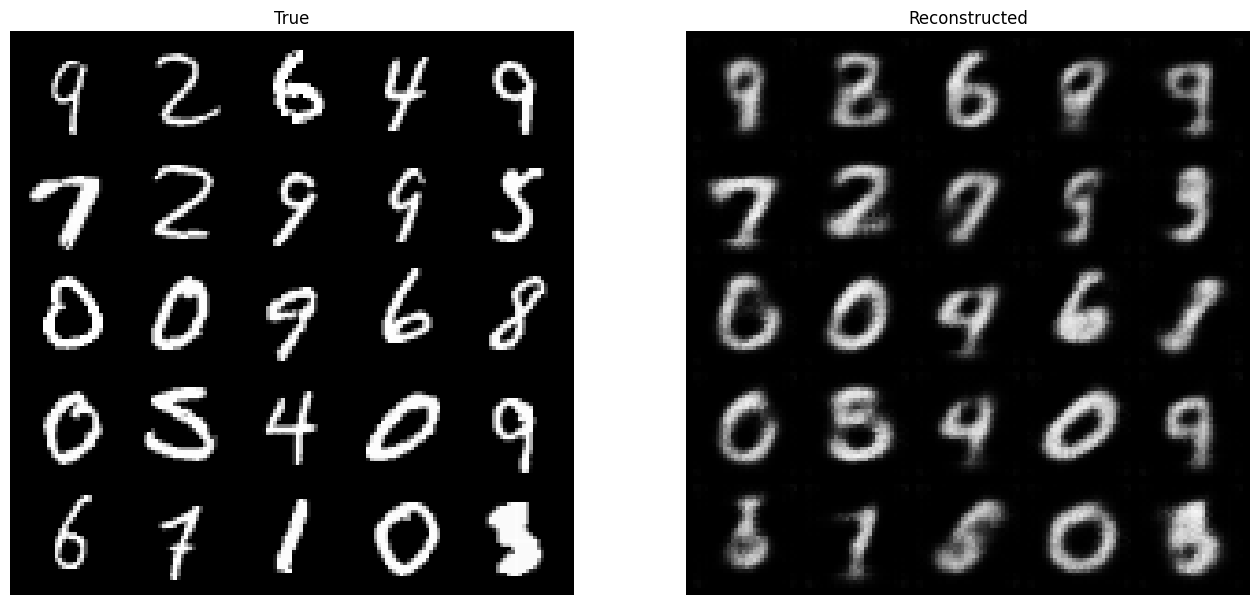

Epoch 2


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.98it/s]


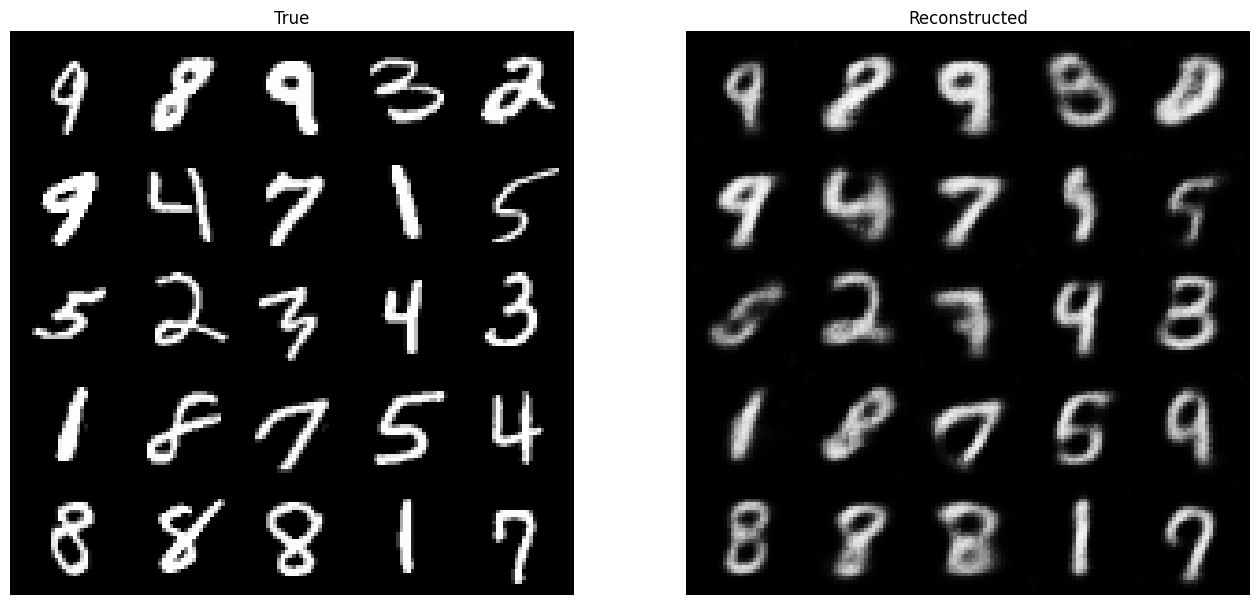

Epoch 3


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  8.00it/s]


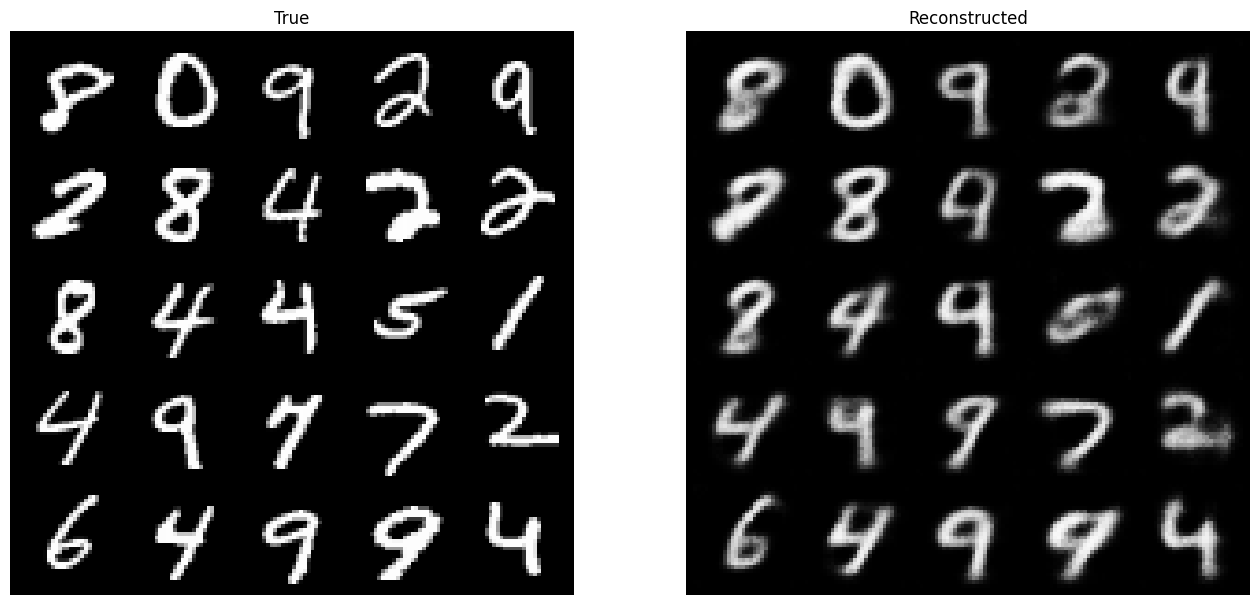

Epoch 4


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.78it/s]


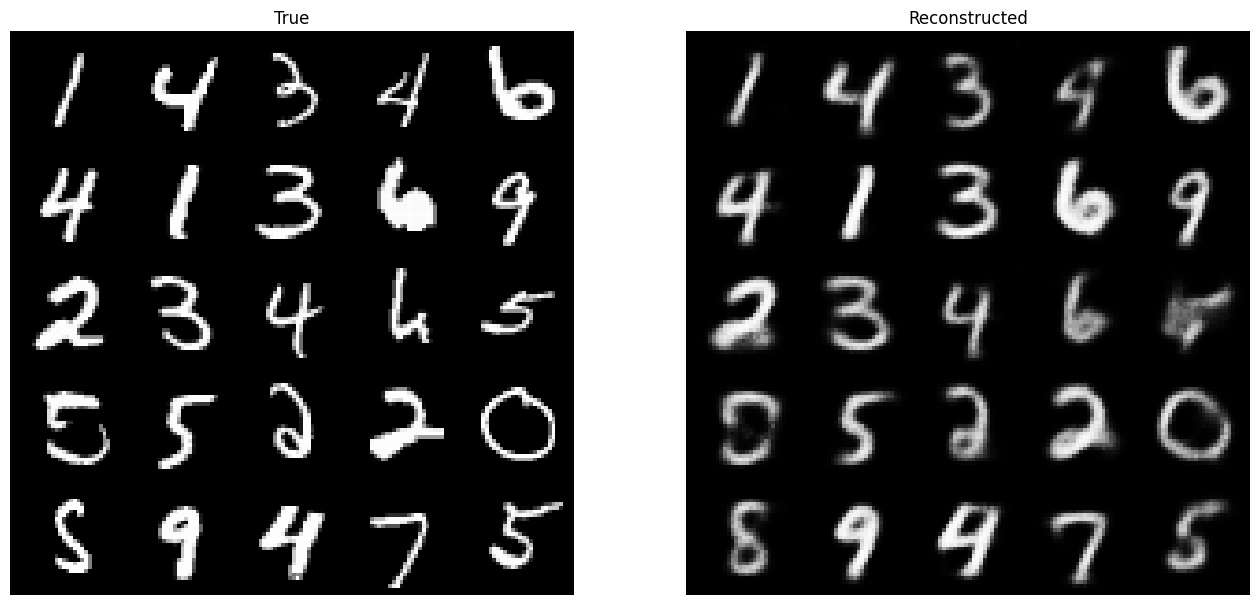

Epoch 5


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  8.02it/s]


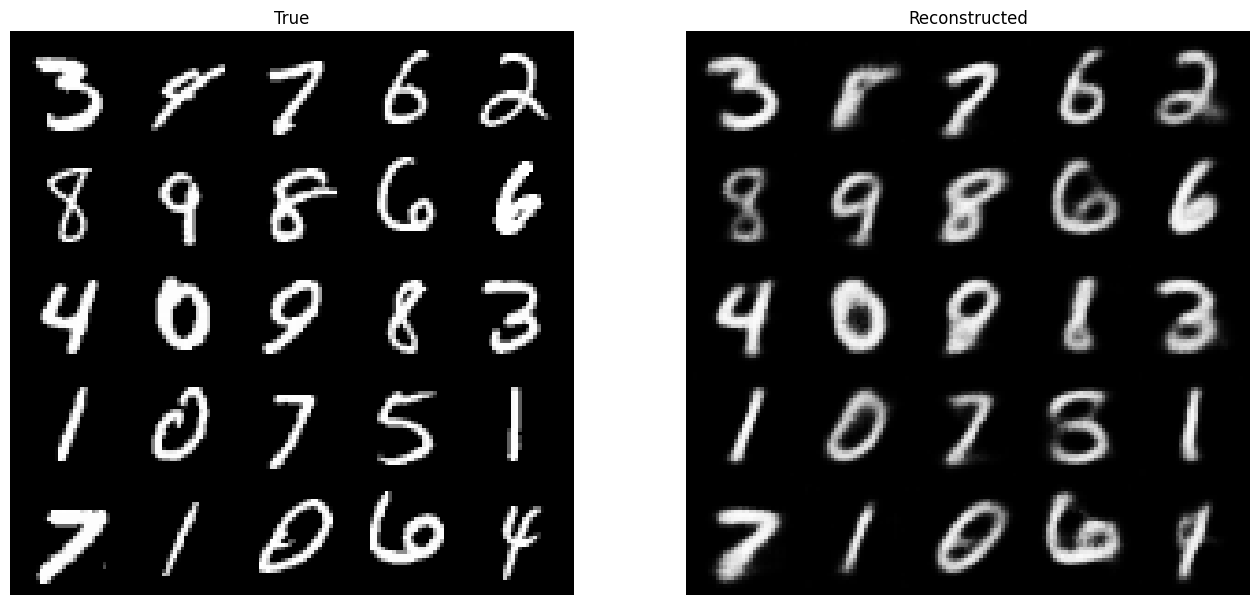

Epoch 6


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.96it/s]


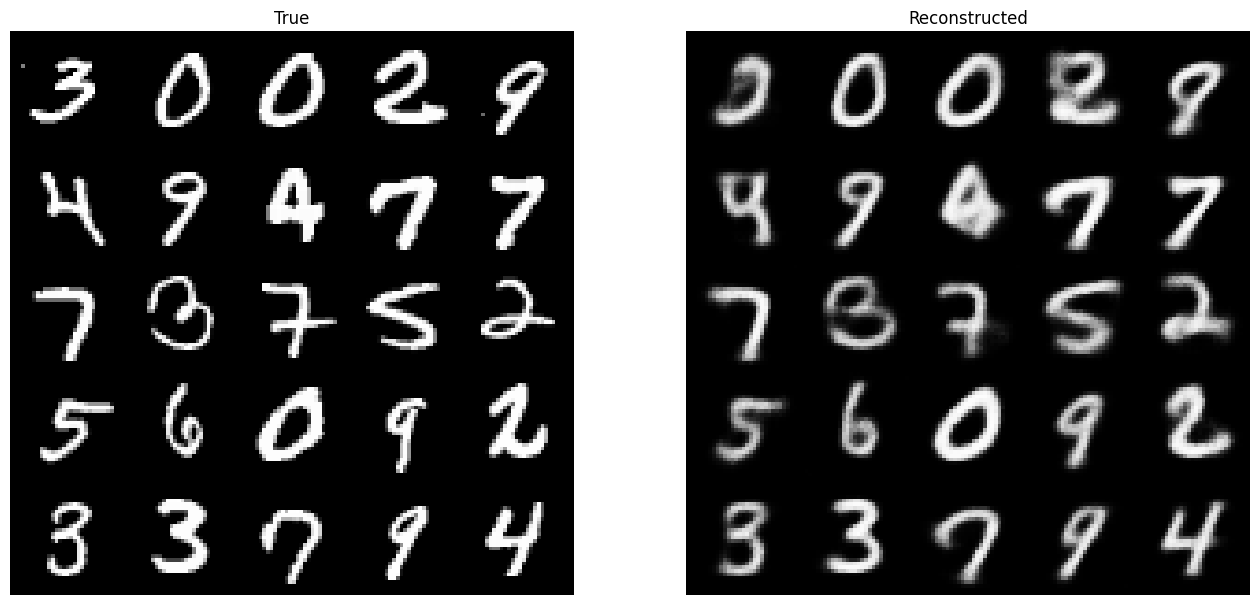

Epoch 7


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.99it/s]


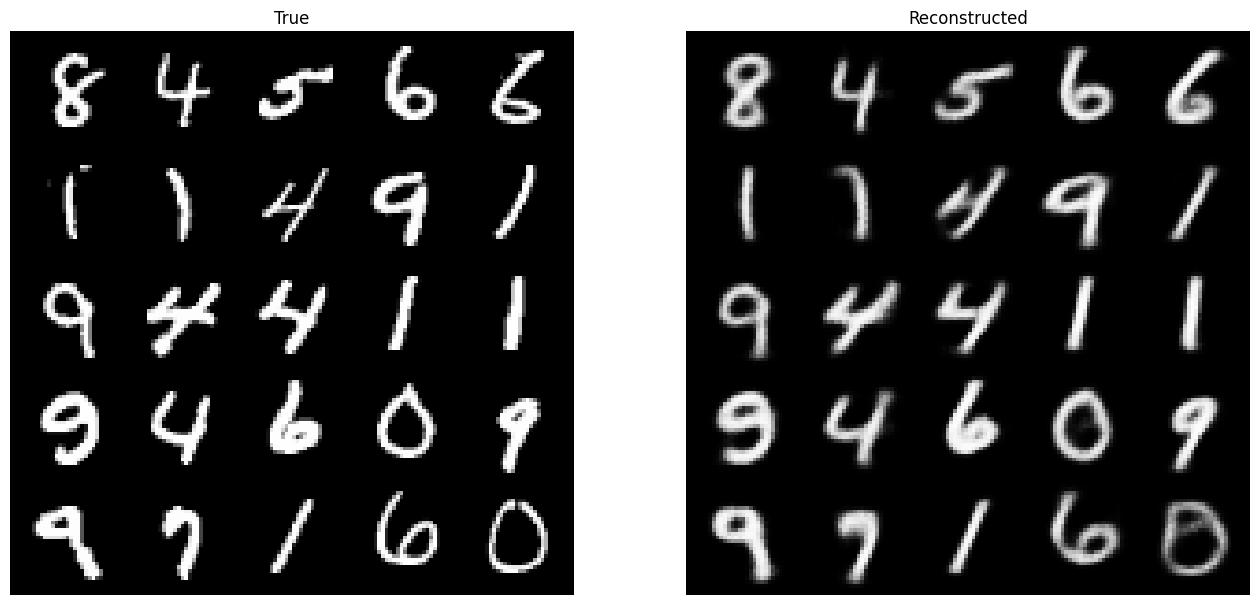

Epoch 8


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.97it/s]


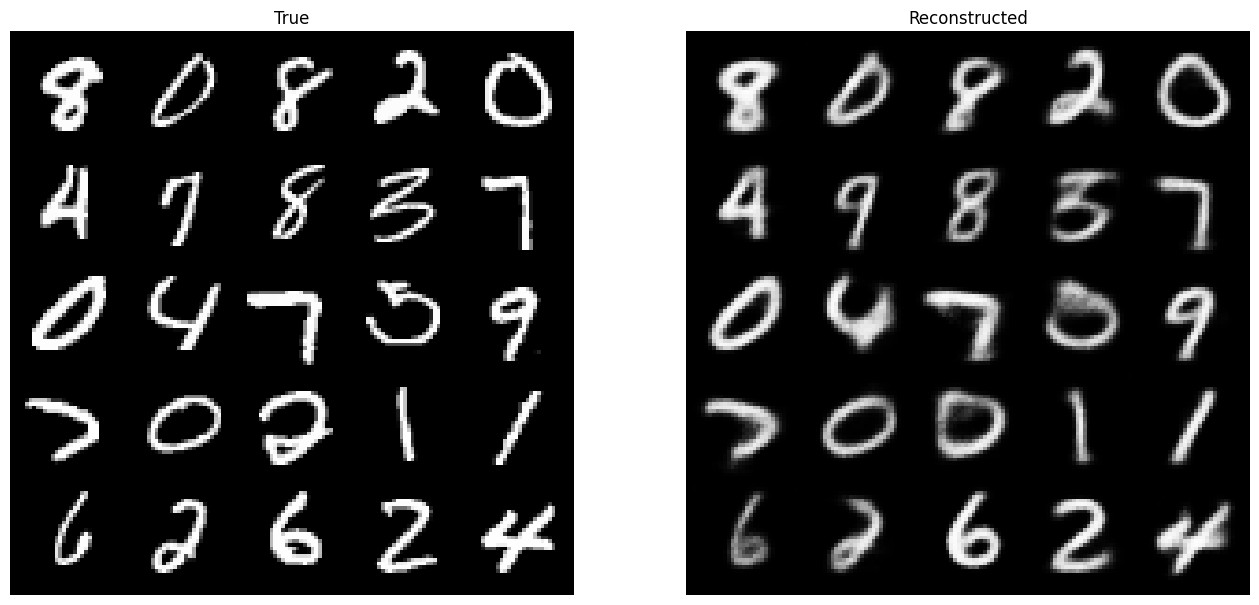

Epoch 9


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.97it/s]


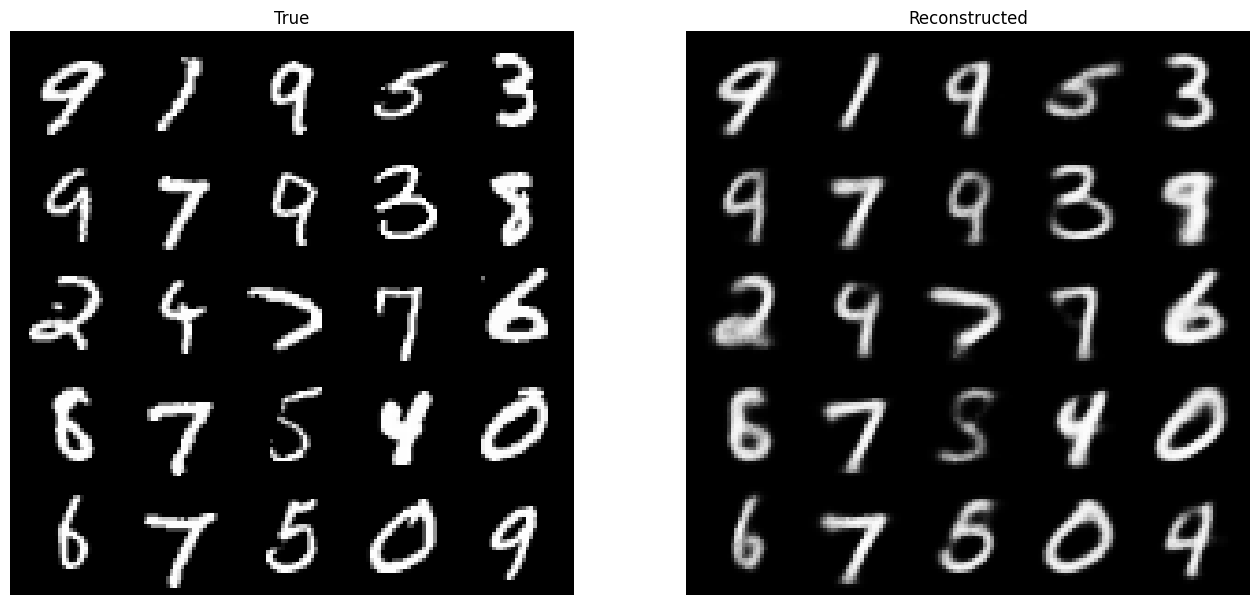

Epoch 10


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.98it/s]


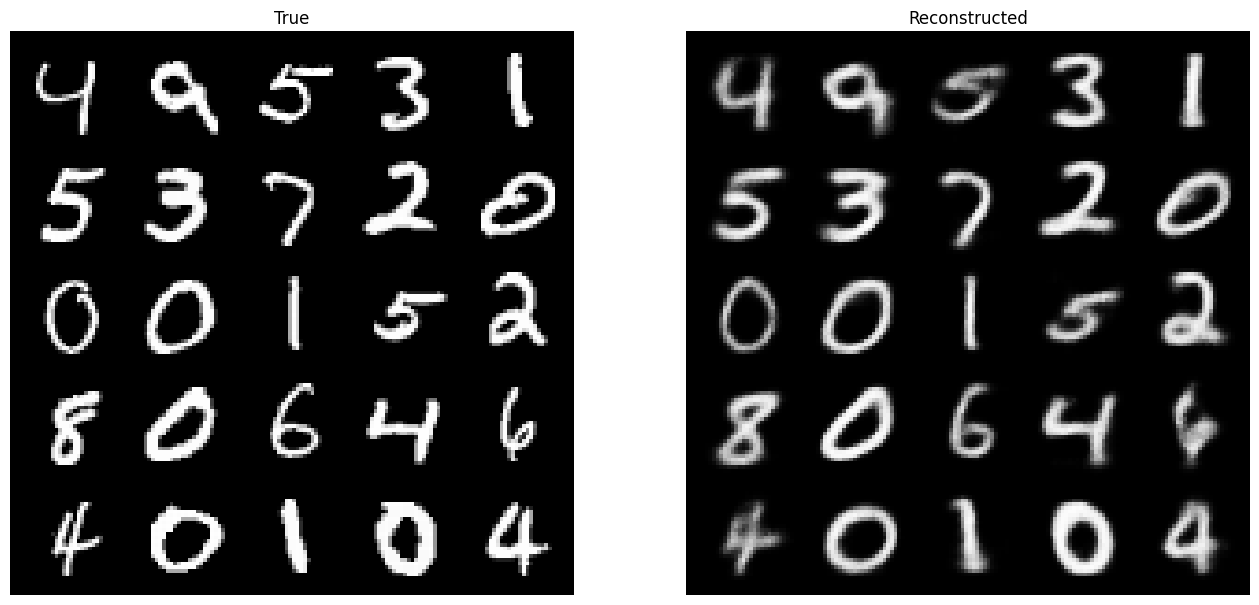

Epoch 11


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  8.00it/s]


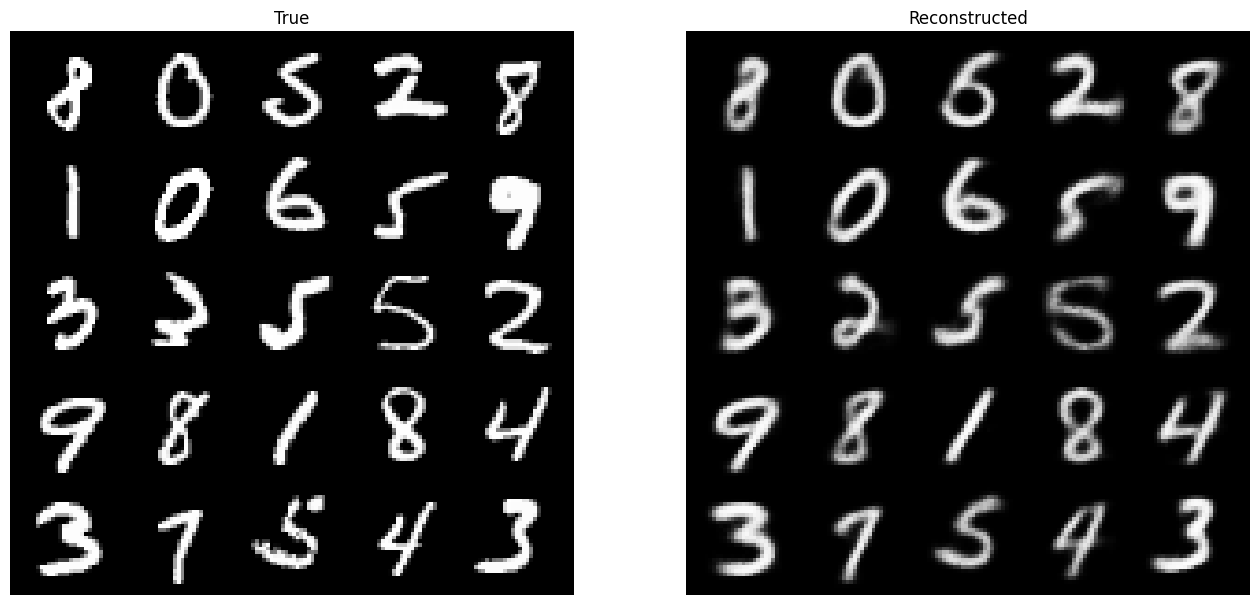

Epoch 12


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.77it/s]


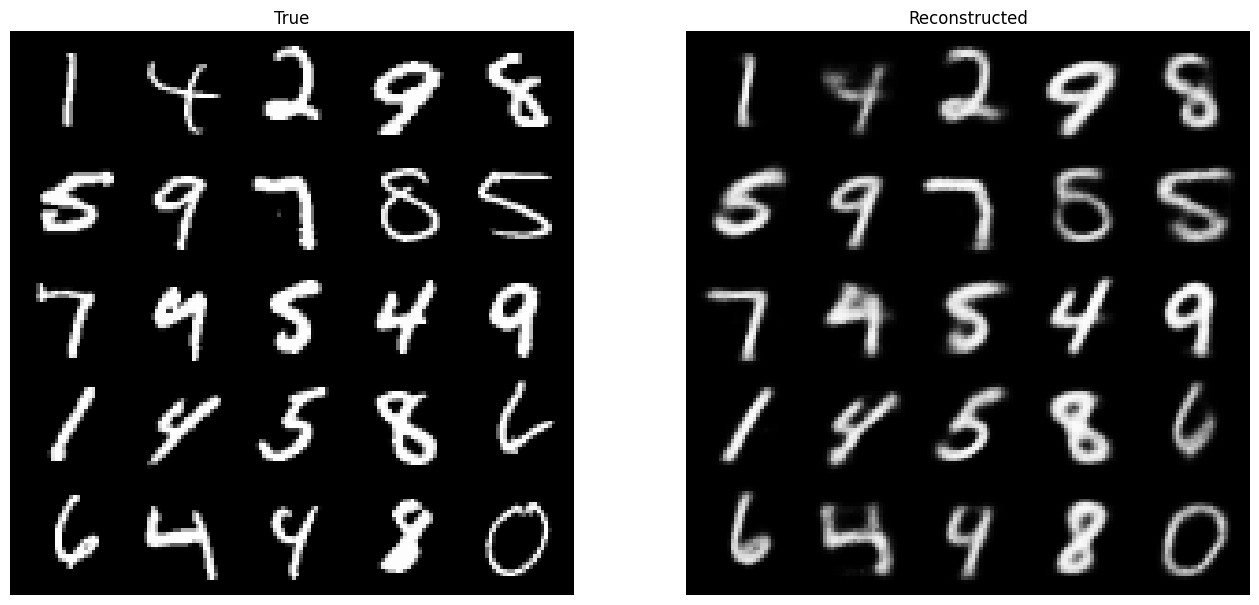

Epoch 13


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.97it/s]


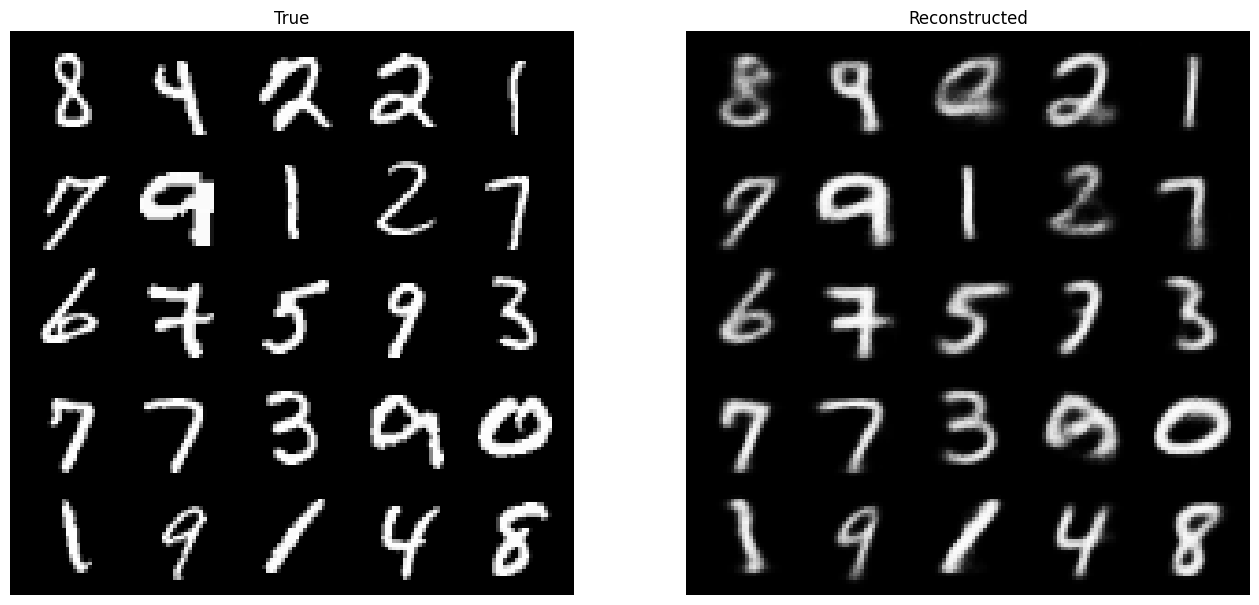

Epoch 14


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.95it/s]


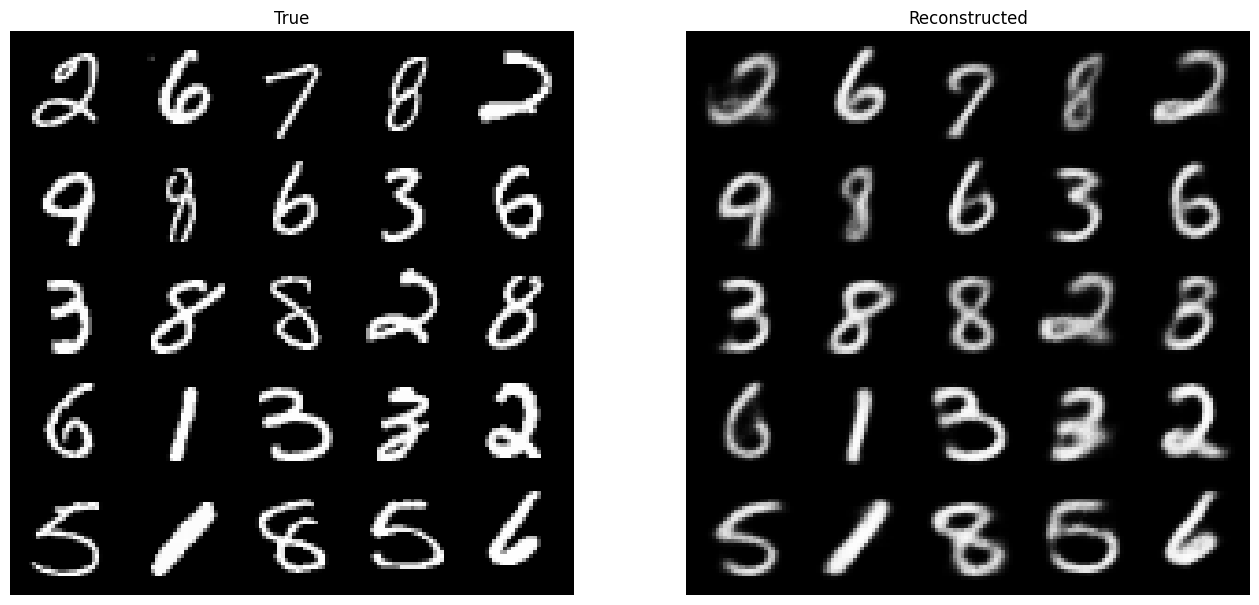

Epoch 15


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.97it/s]


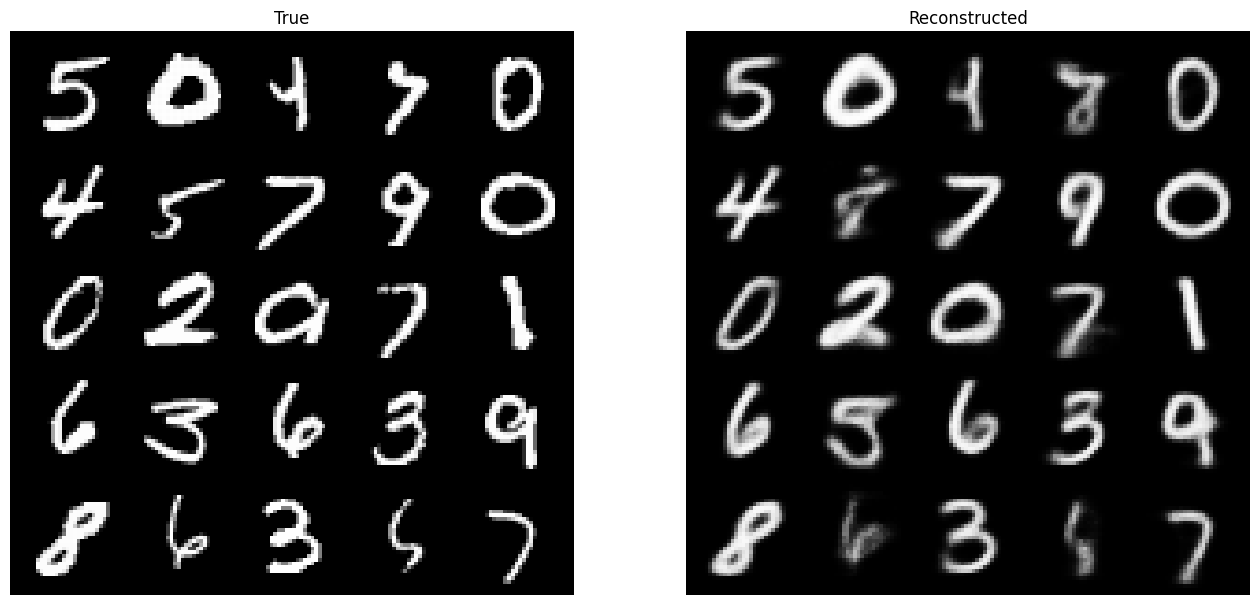

Epoch 16


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.97it/s]


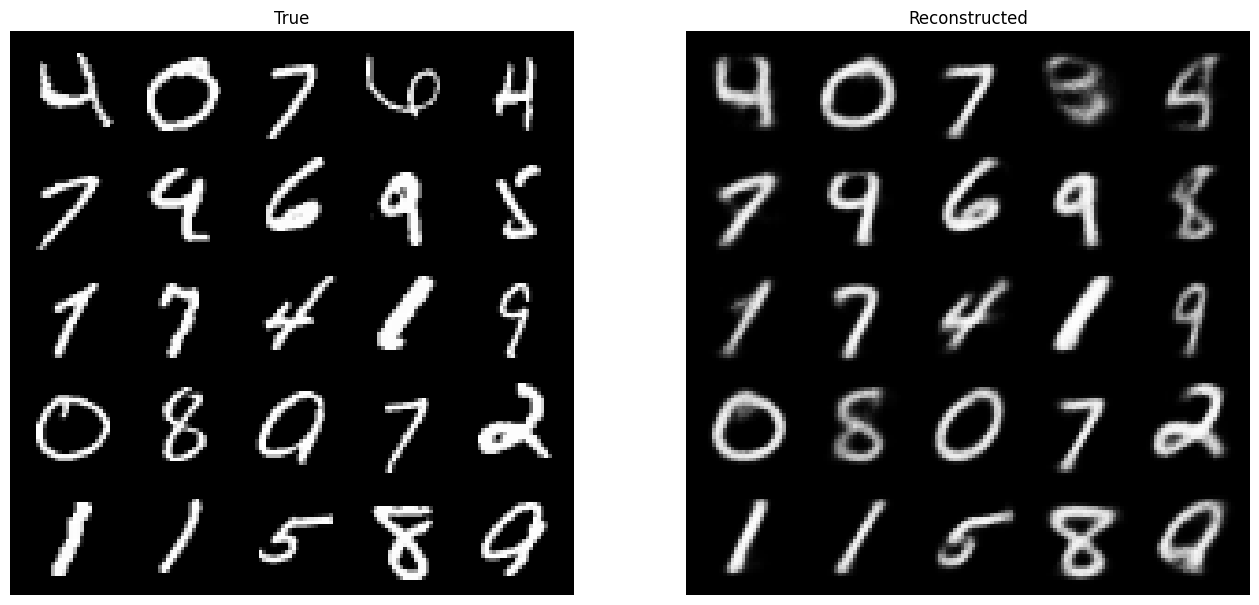

Epoch 17


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.93it/s]


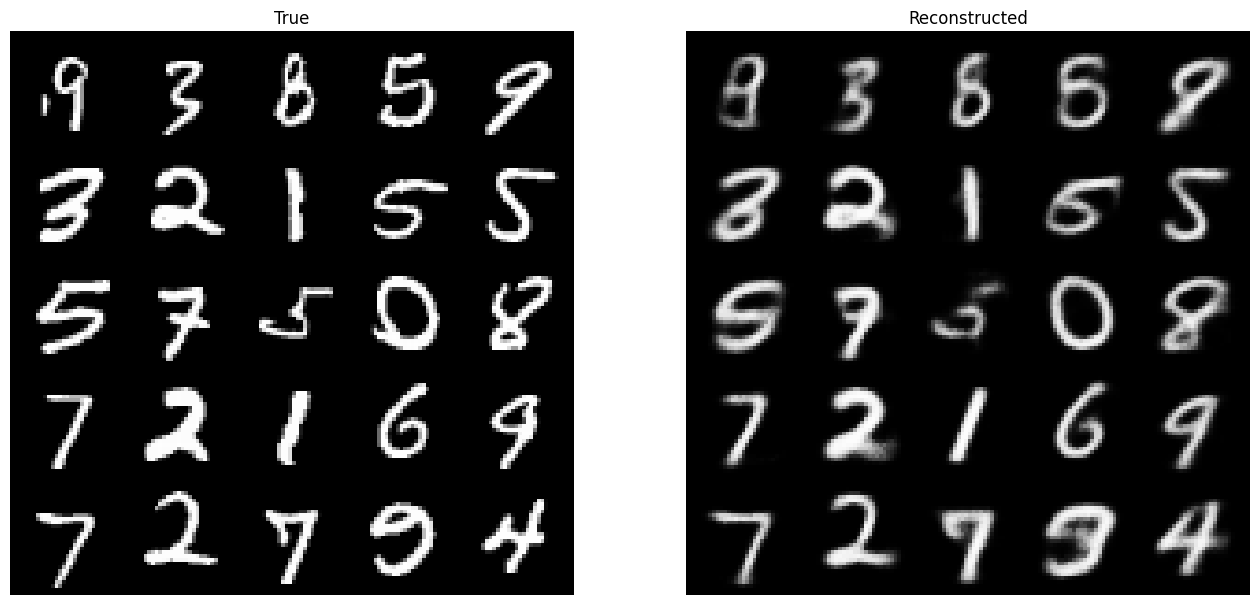

Epoch 18


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.97it/s]


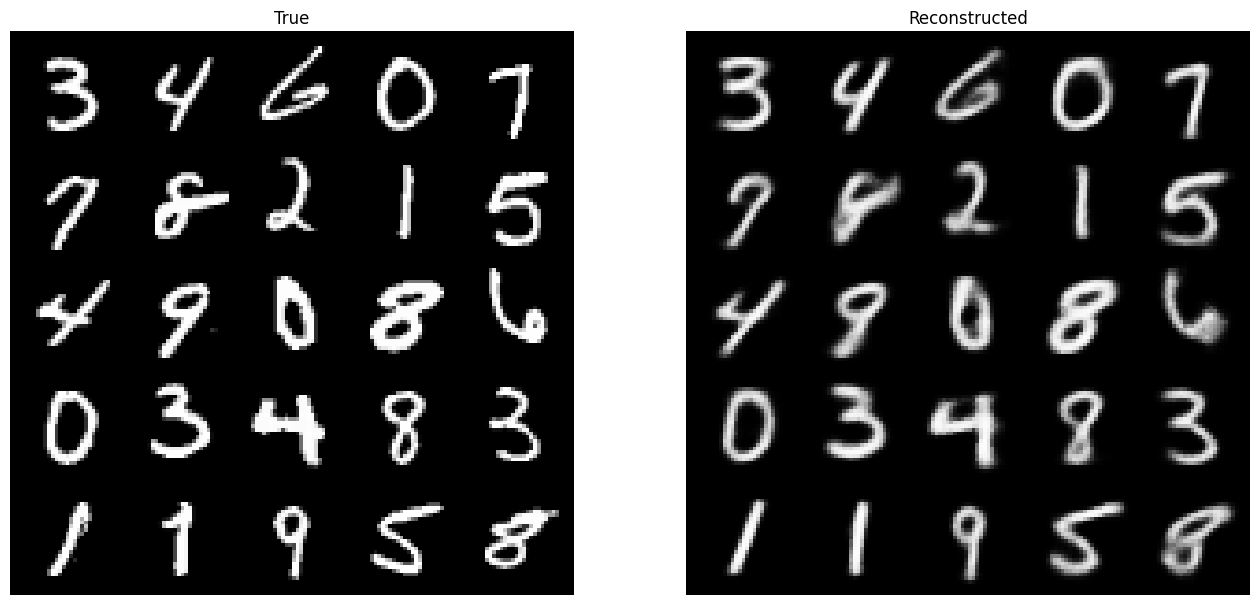

Epoch 19


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.98it/s]


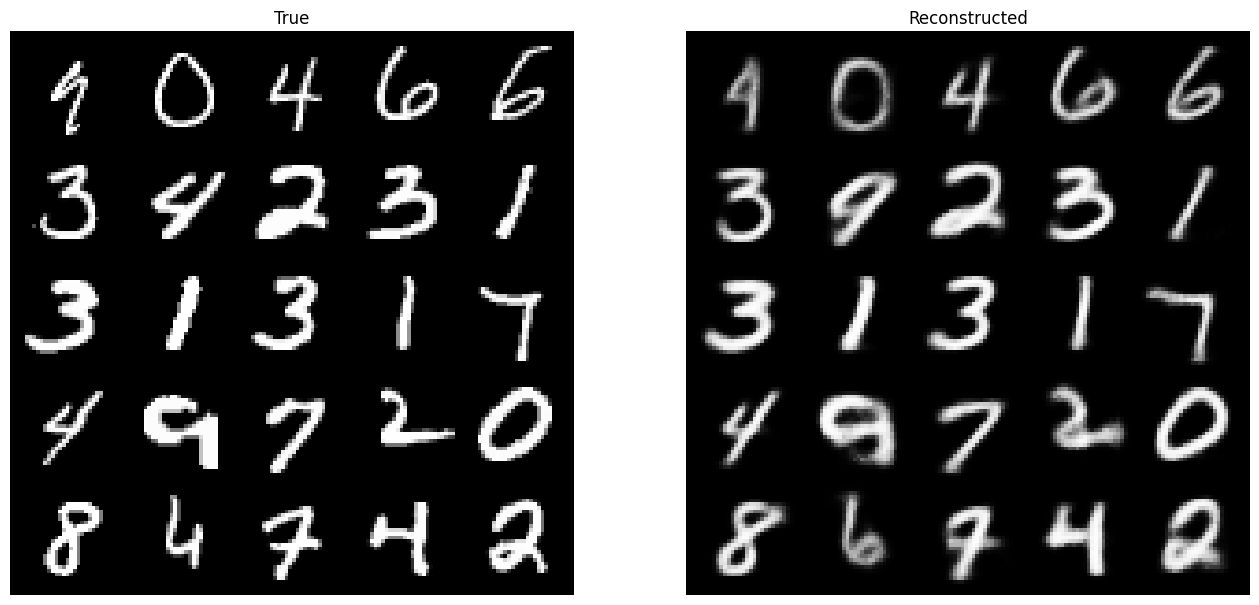

Epoch 20


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.75it/s]


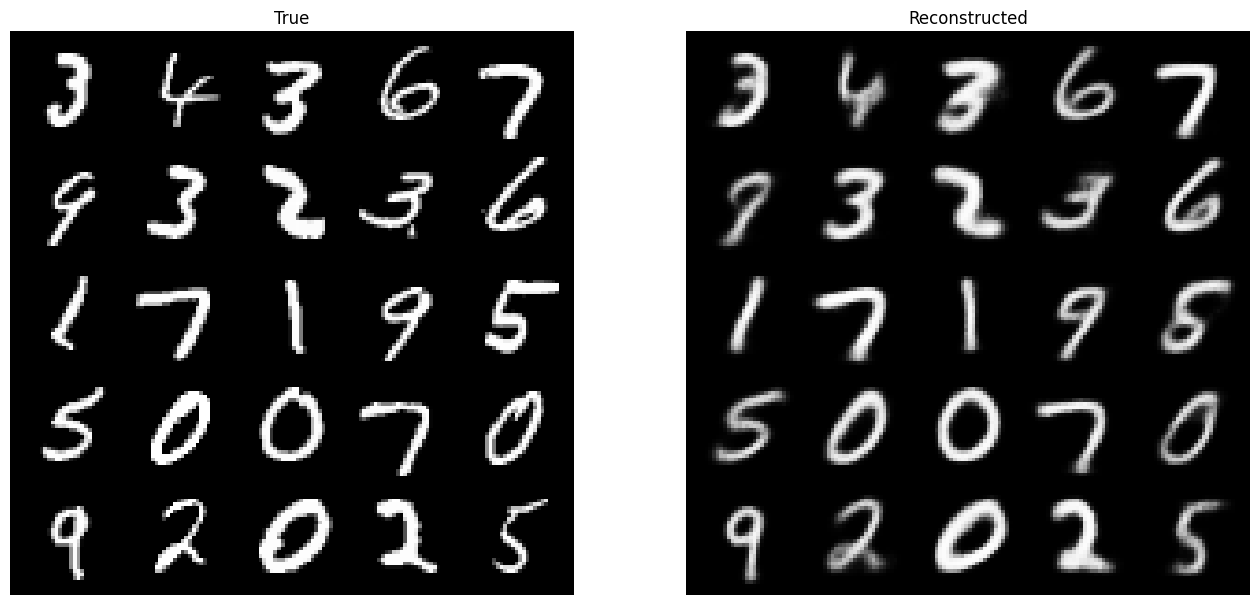

Epoch 21


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.95it/s]


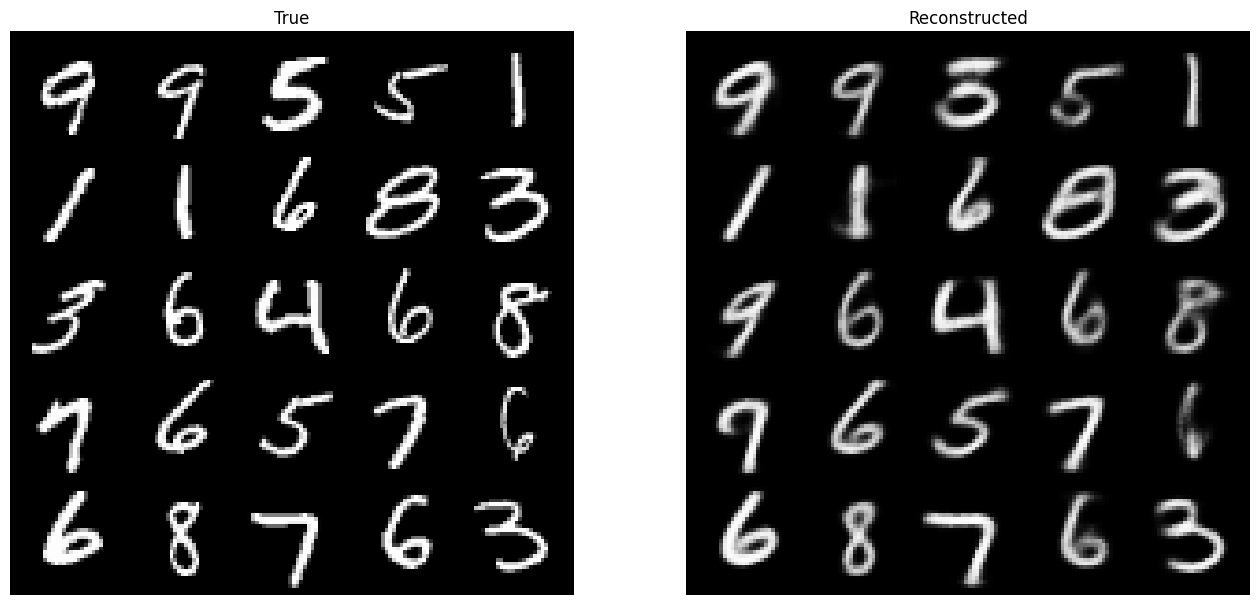

Epoch 22


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.97it/s]


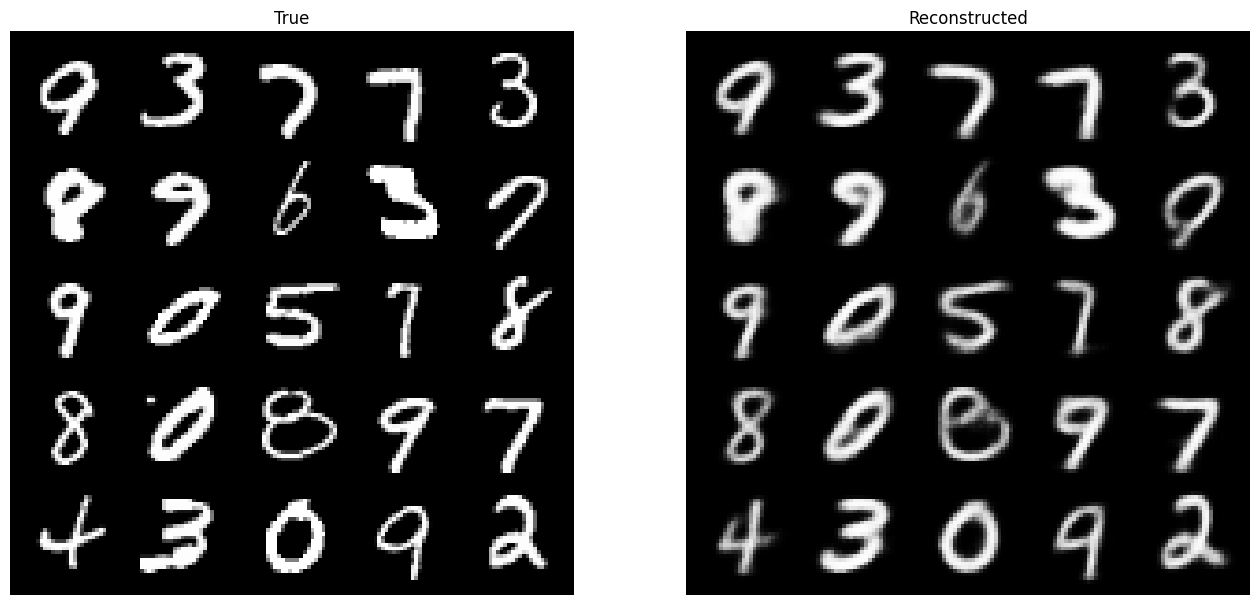

Epoch 23


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.97it/s]


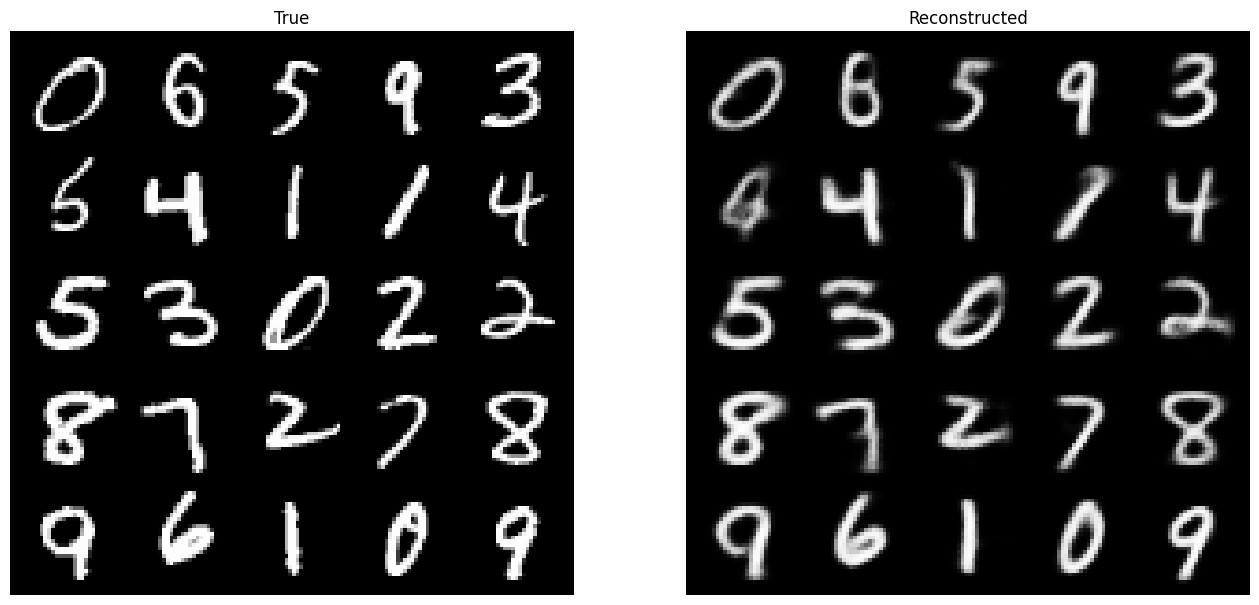

Epoch 24


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.95it/s]


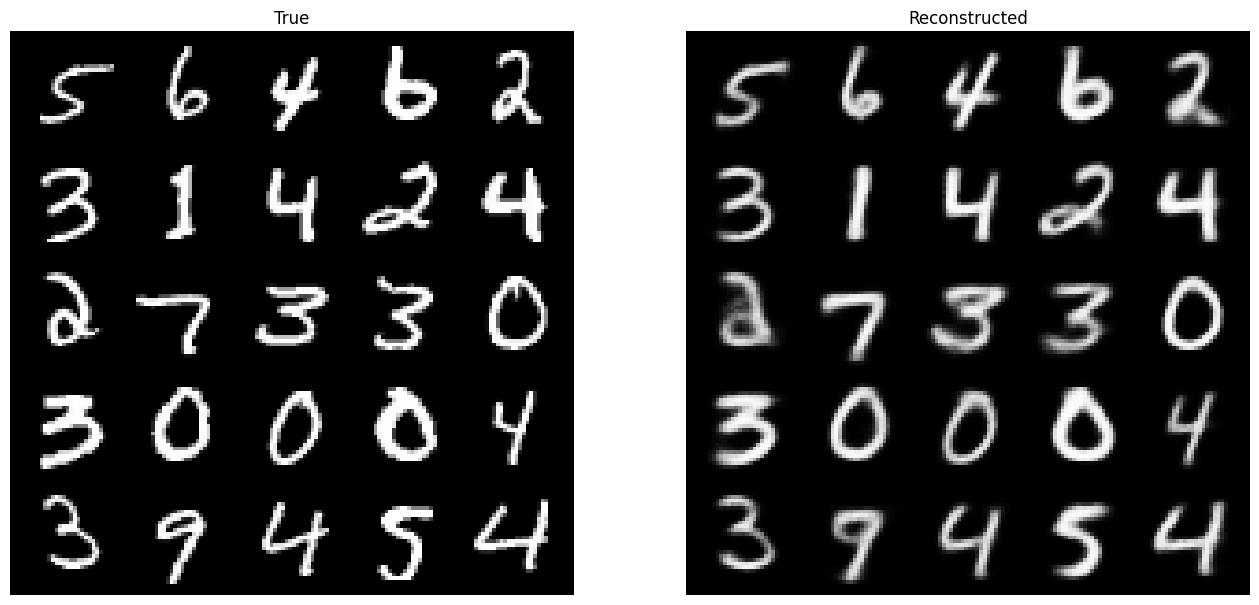

Epoch 25


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.96it/s]


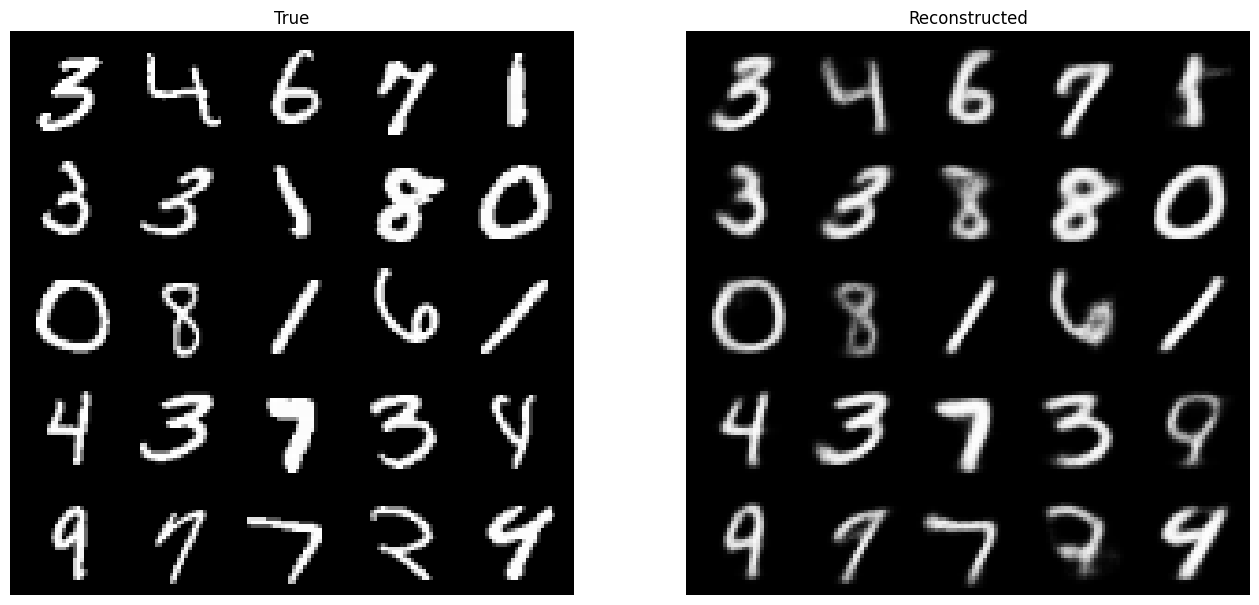

Epoch 26


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.97it/s]


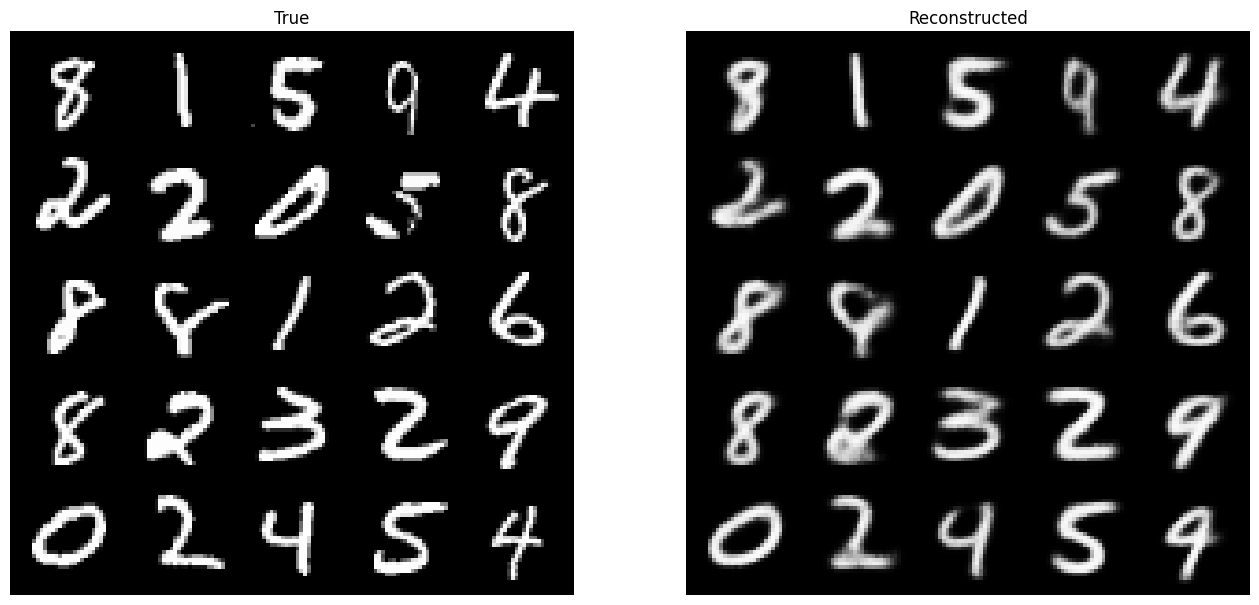

Epoch 27


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.97it/s]


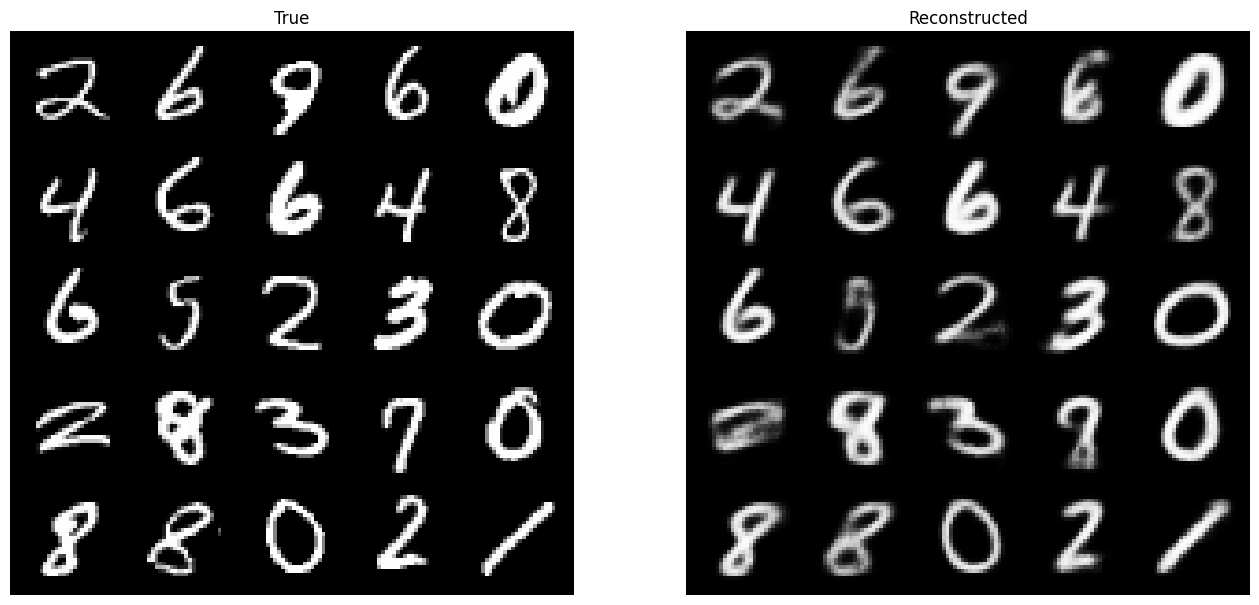

Epoch 28


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.76it/s]


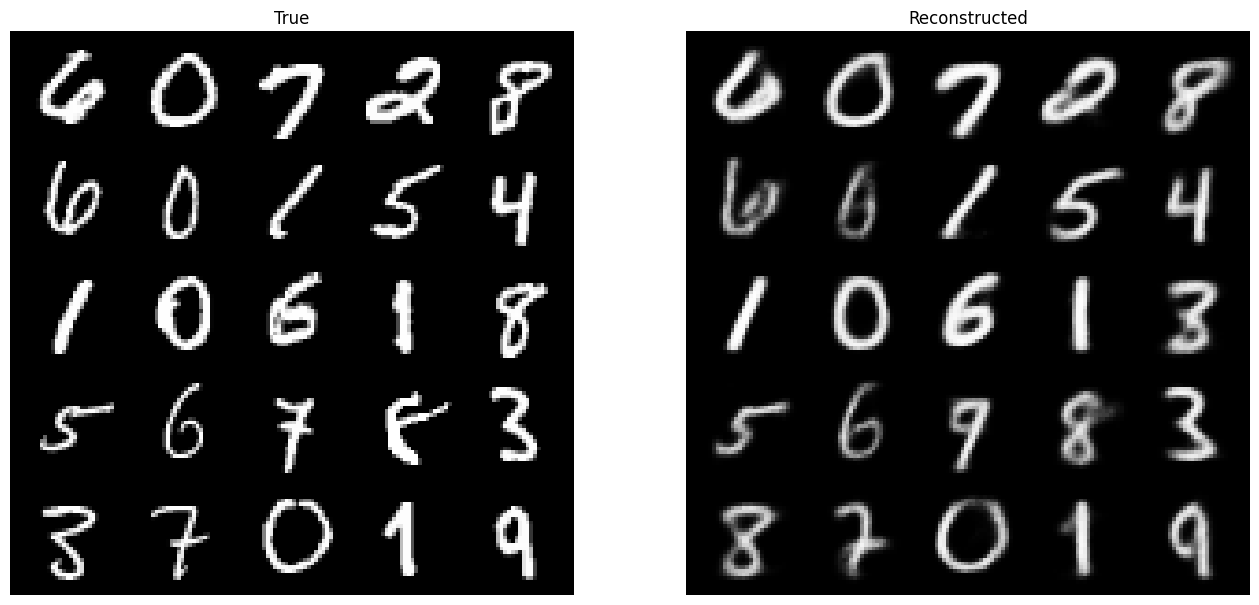

Epoch 29


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.92it/s]


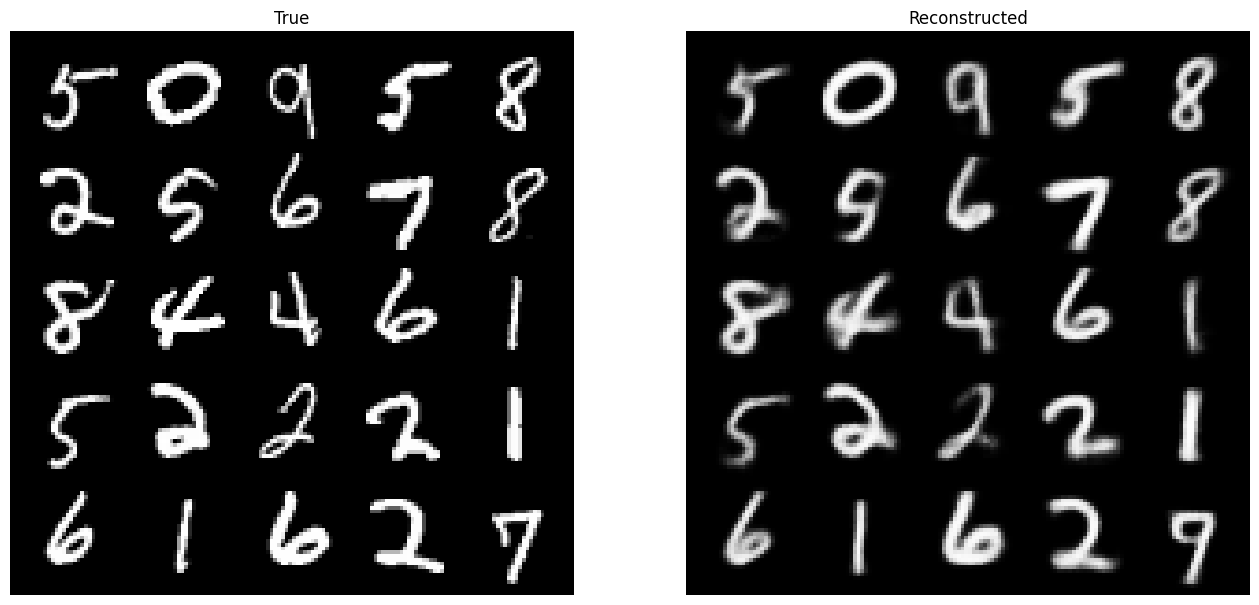

Epoch 30


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.90it/s]


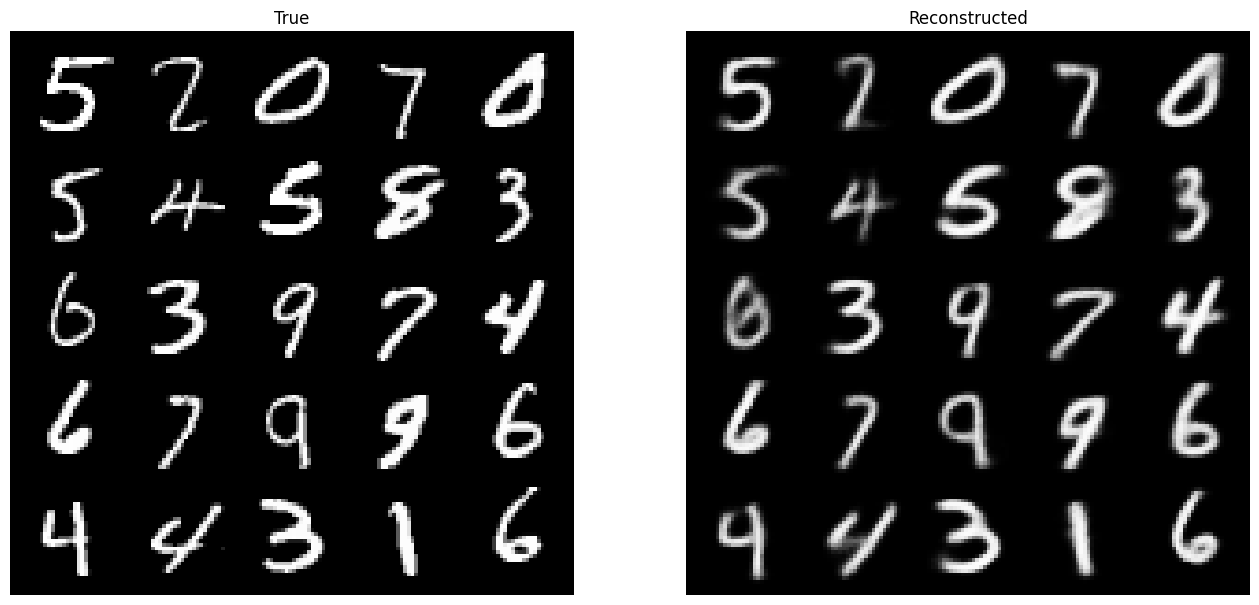

Epoch 31


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.81it/s]


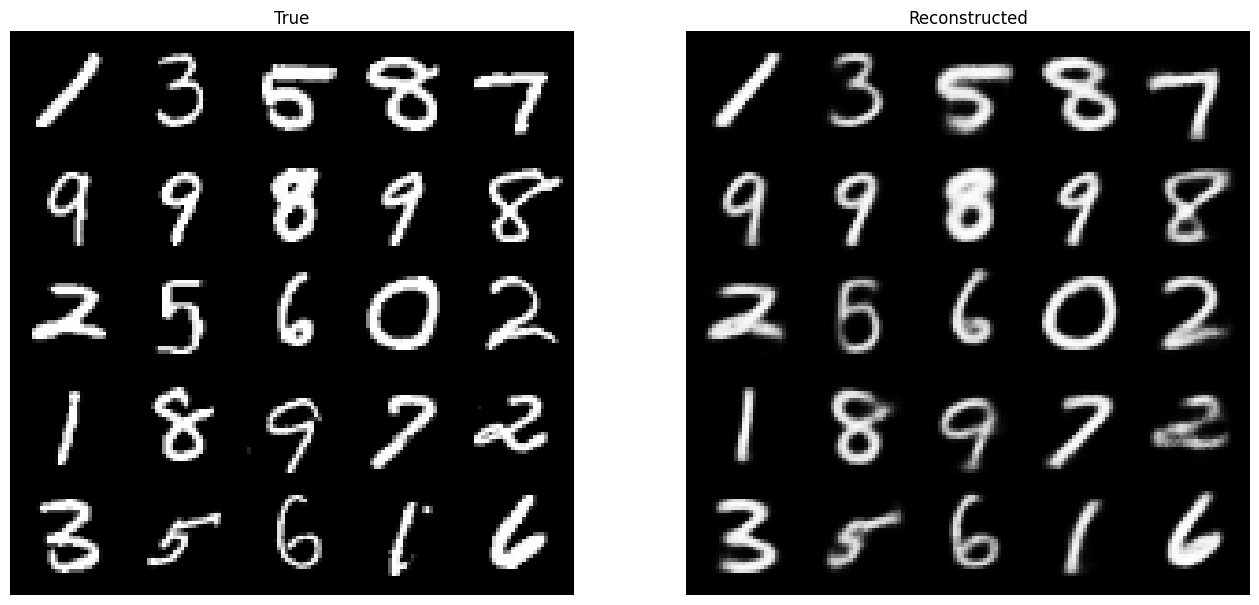

Epoch 32


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.87it/s]


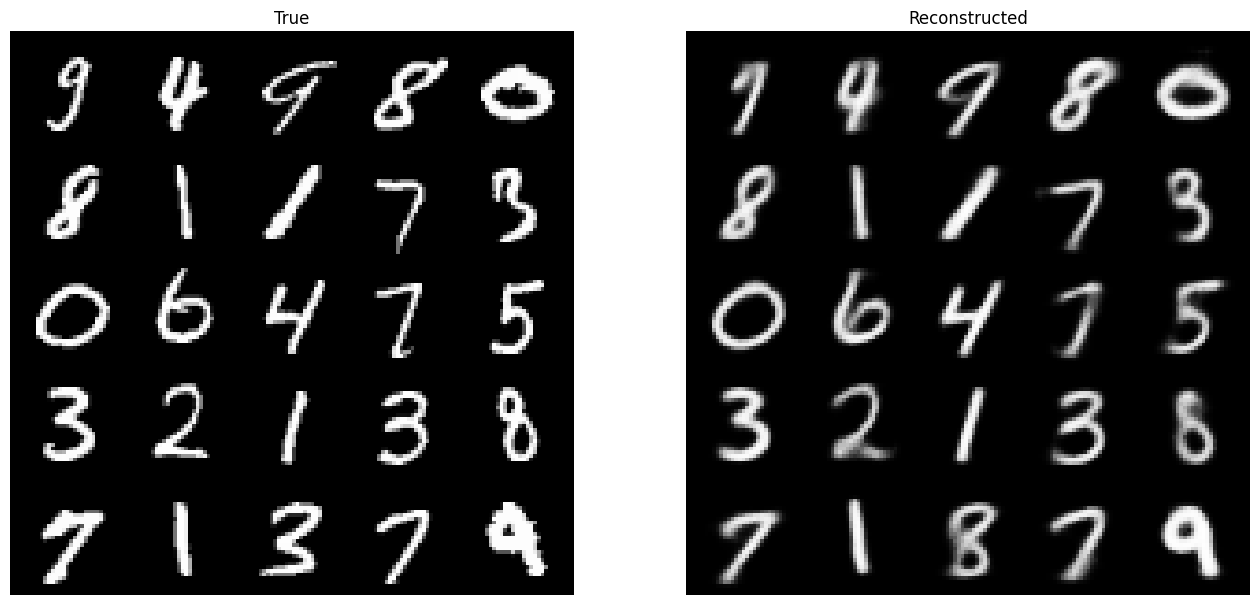

Epoch 33


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.93it/s]


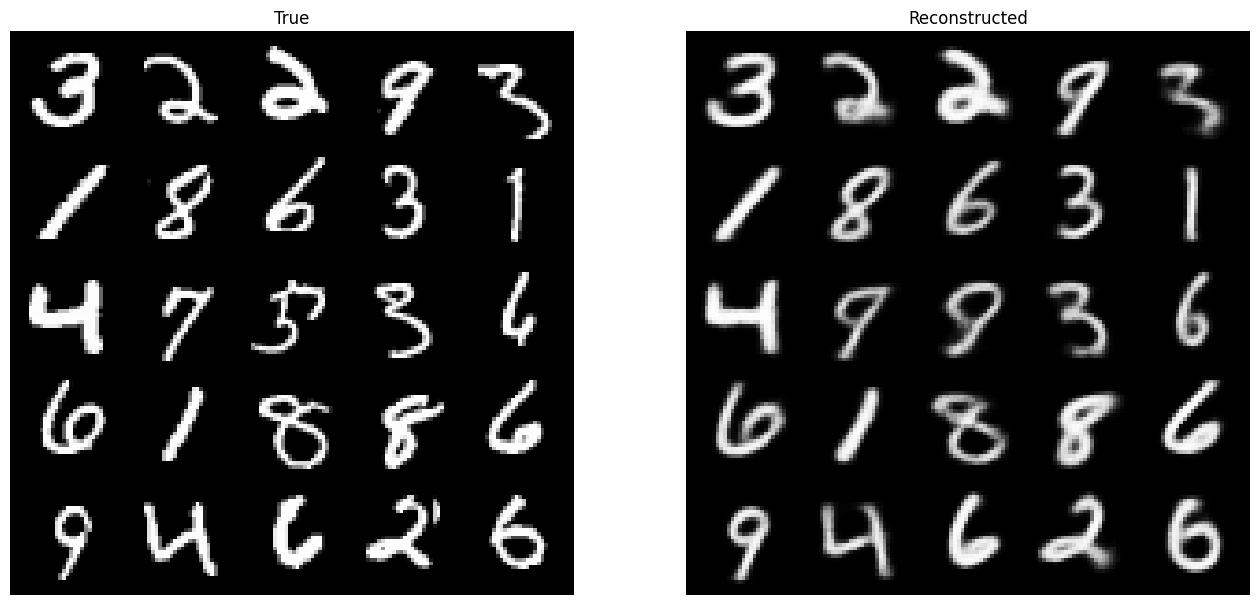

Epoch 34


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.71it/s]


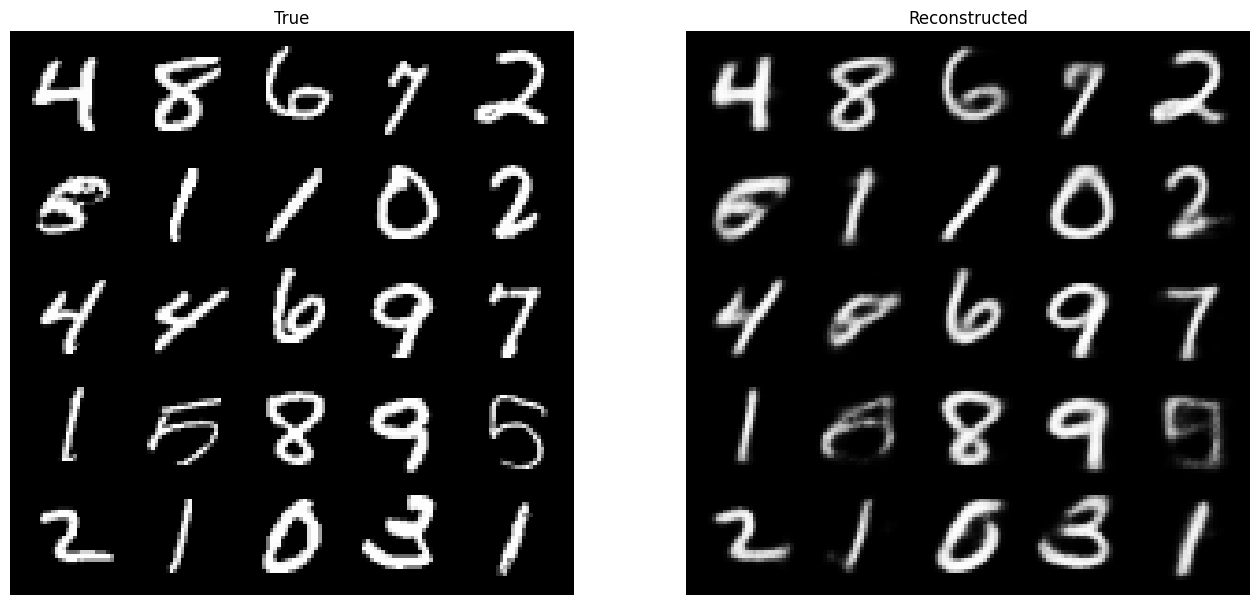

Epoch 35


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.95it/s]


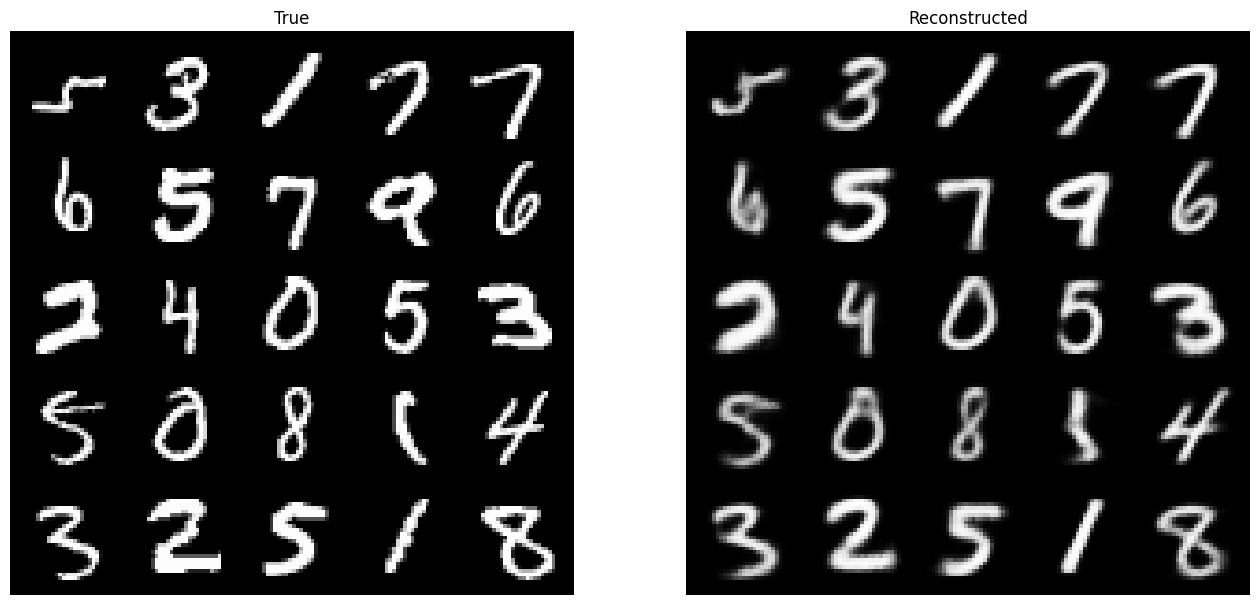

Epoch 36


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.70it/s]


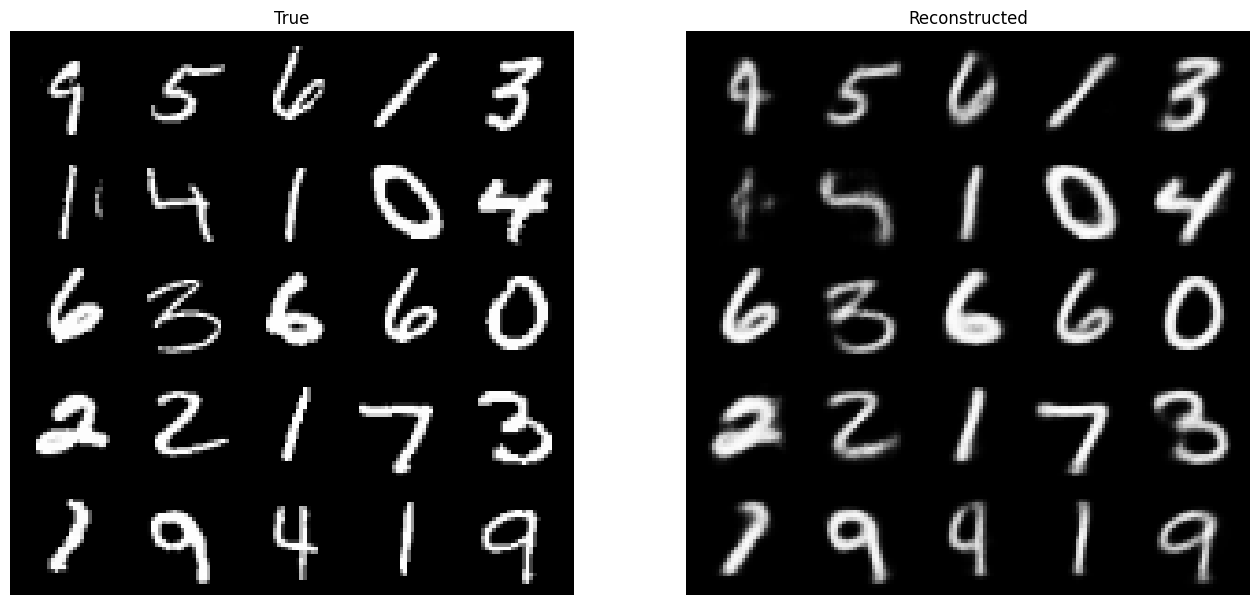

Epoch 37


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.64it/s]


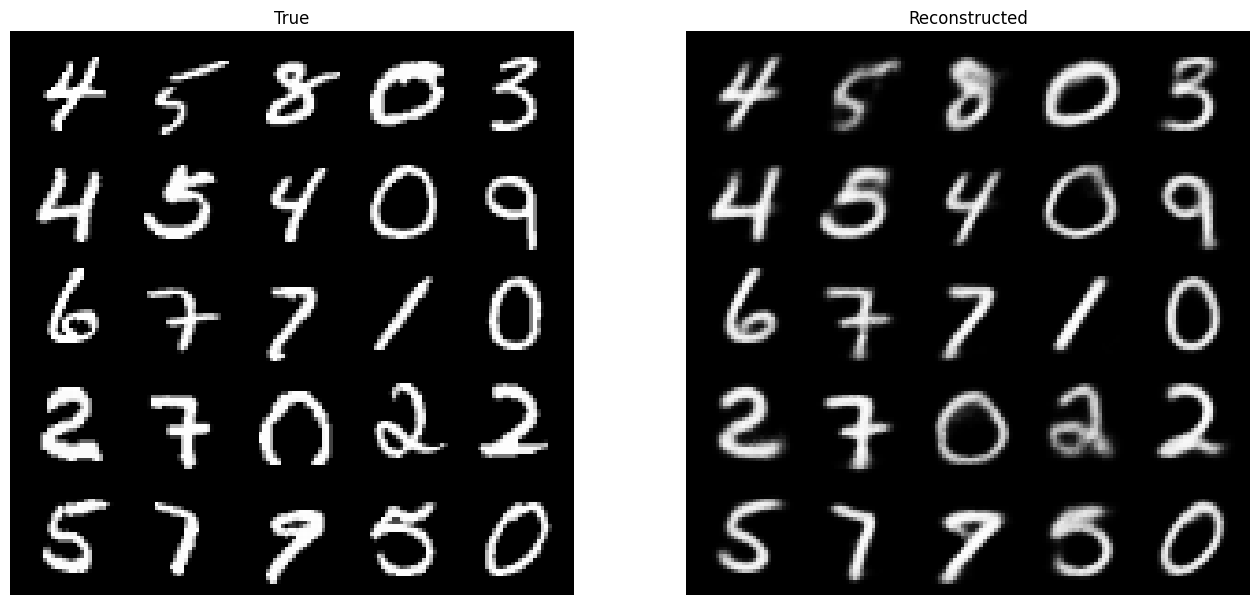

Epoch 38


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.94it/s]


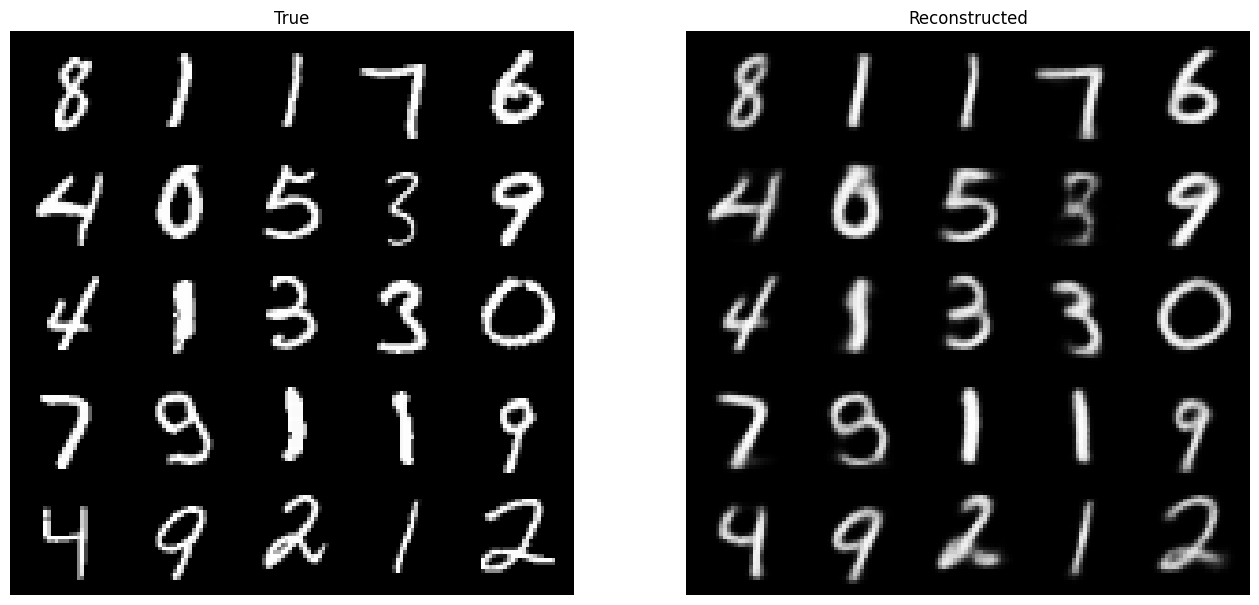

Epoch 39


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.94it/s]


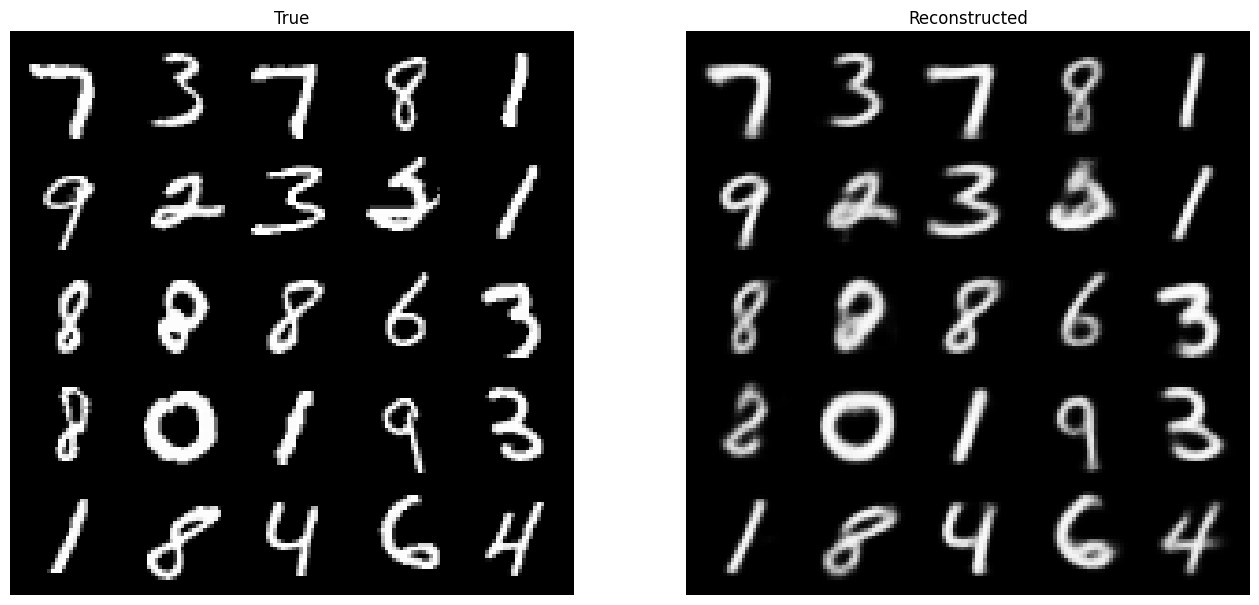

Epoch 40


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.93it/s]


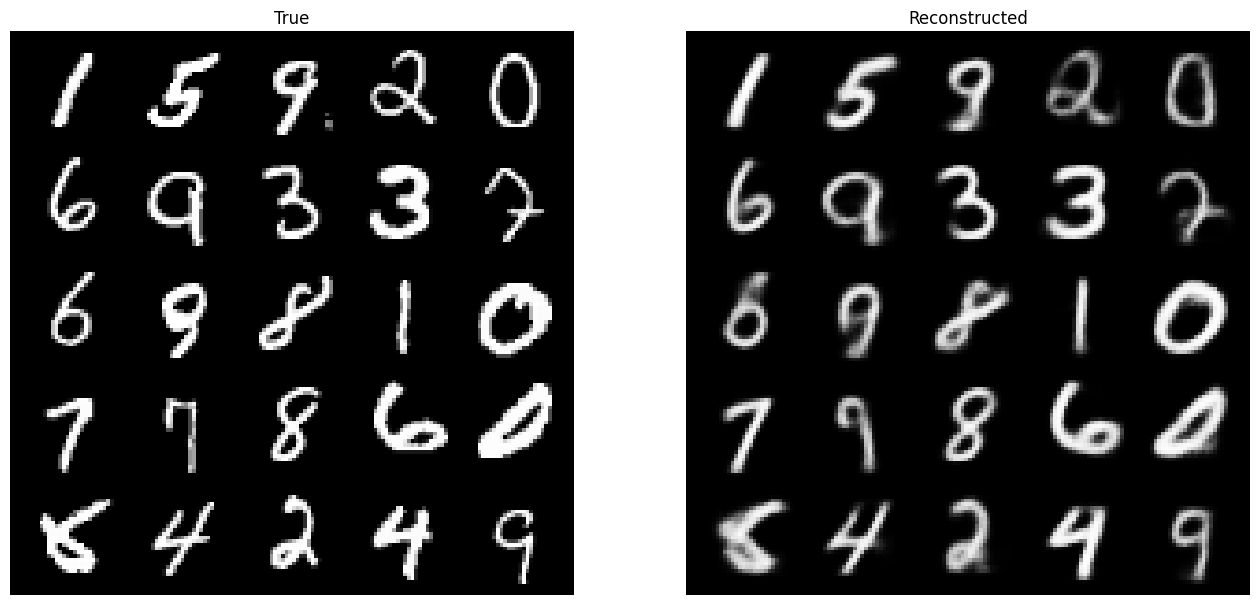

Epoch 41


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.94it/s]


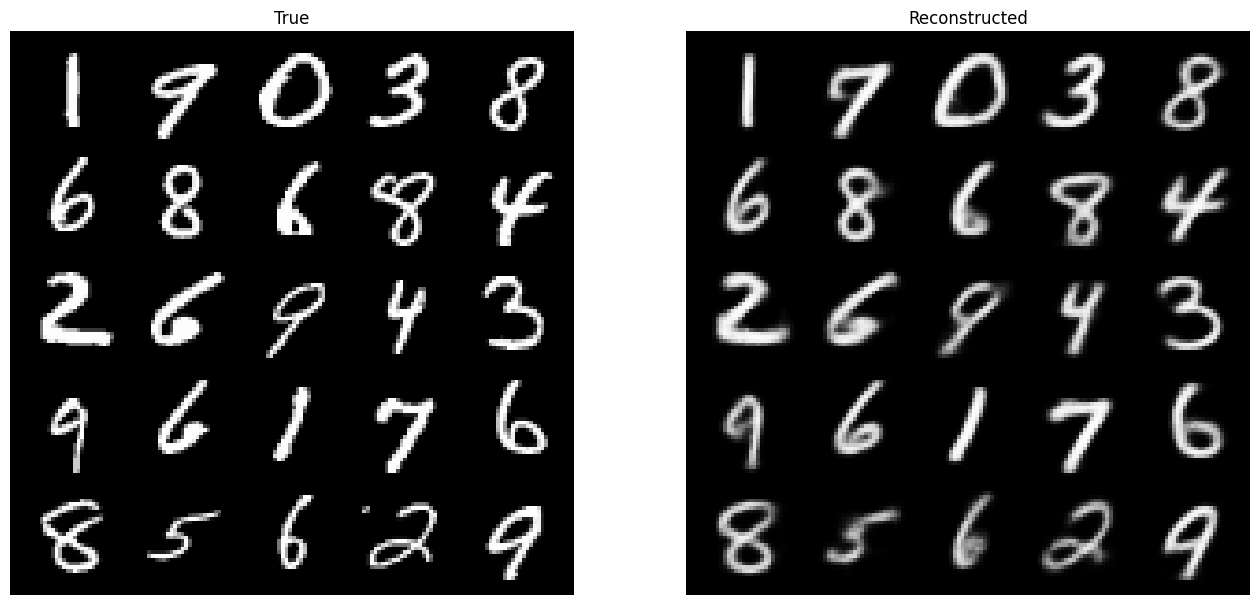

Epoch 42


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.93it/s]


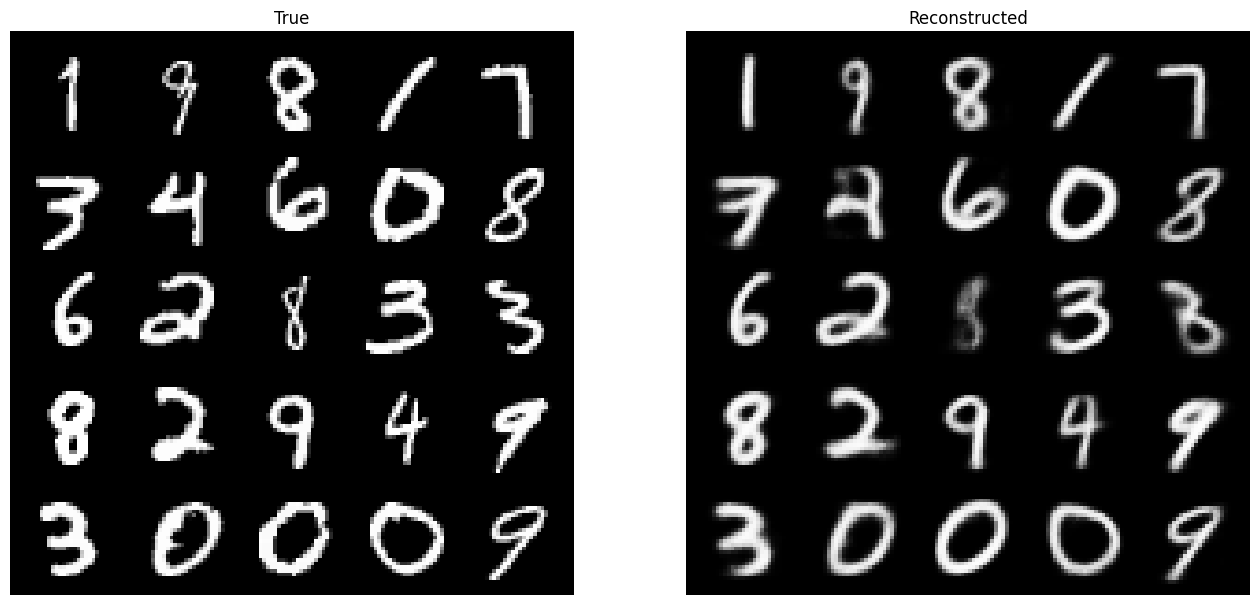

Epoch 43


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.89it/s]


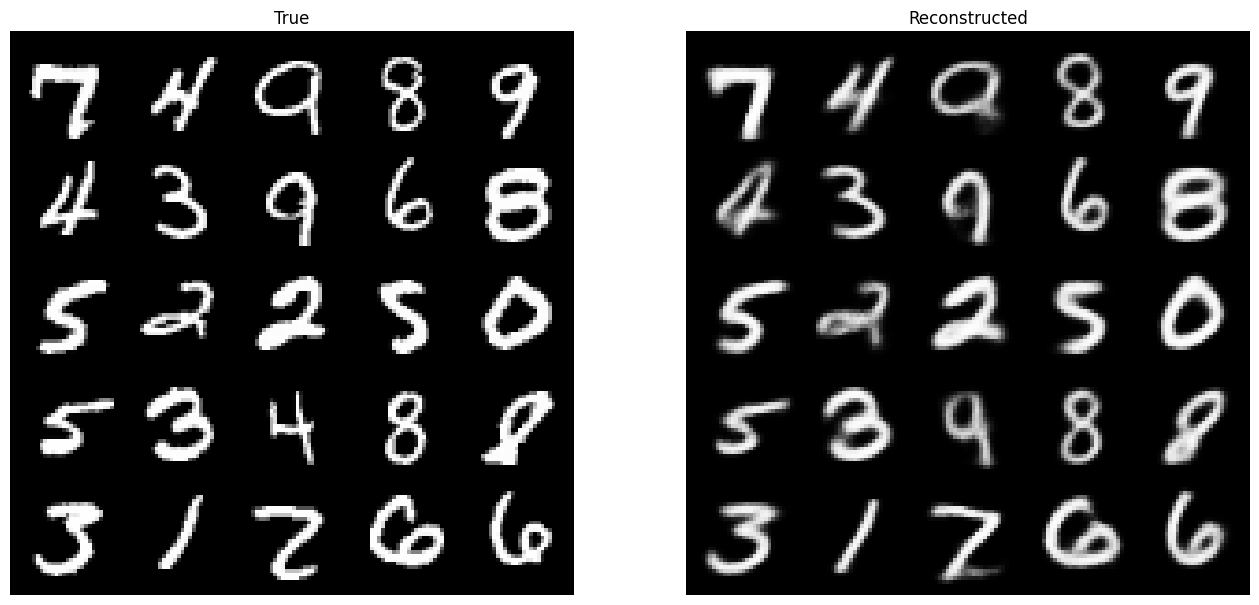

Epoch 44


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.72it/s]


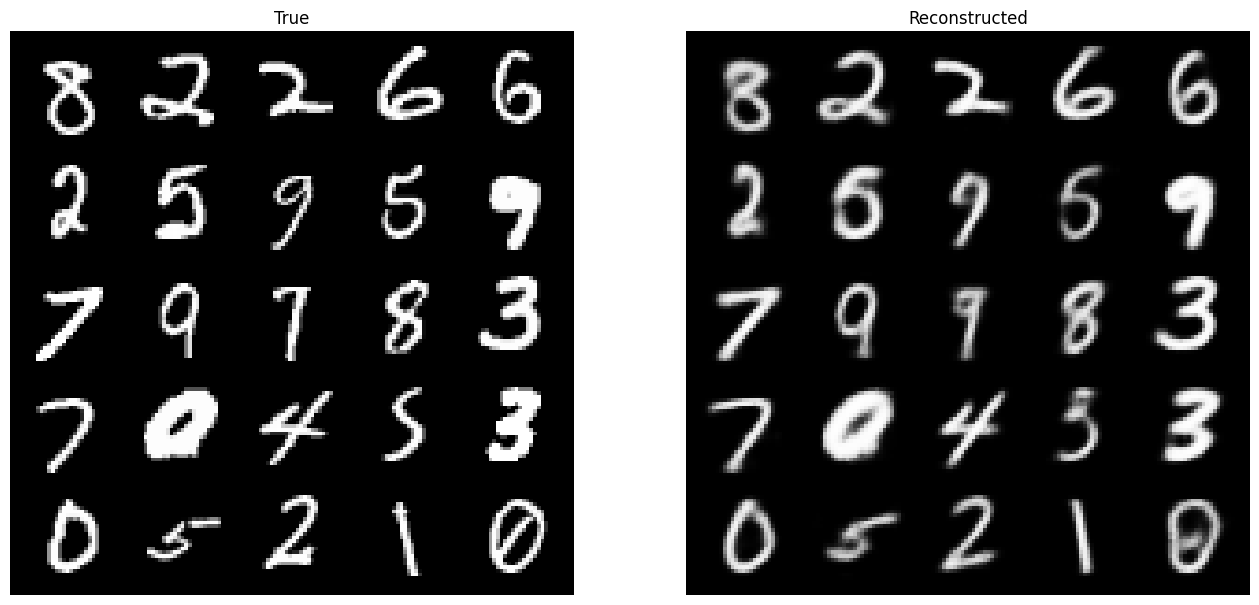

Epoch 45


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.73it/s]


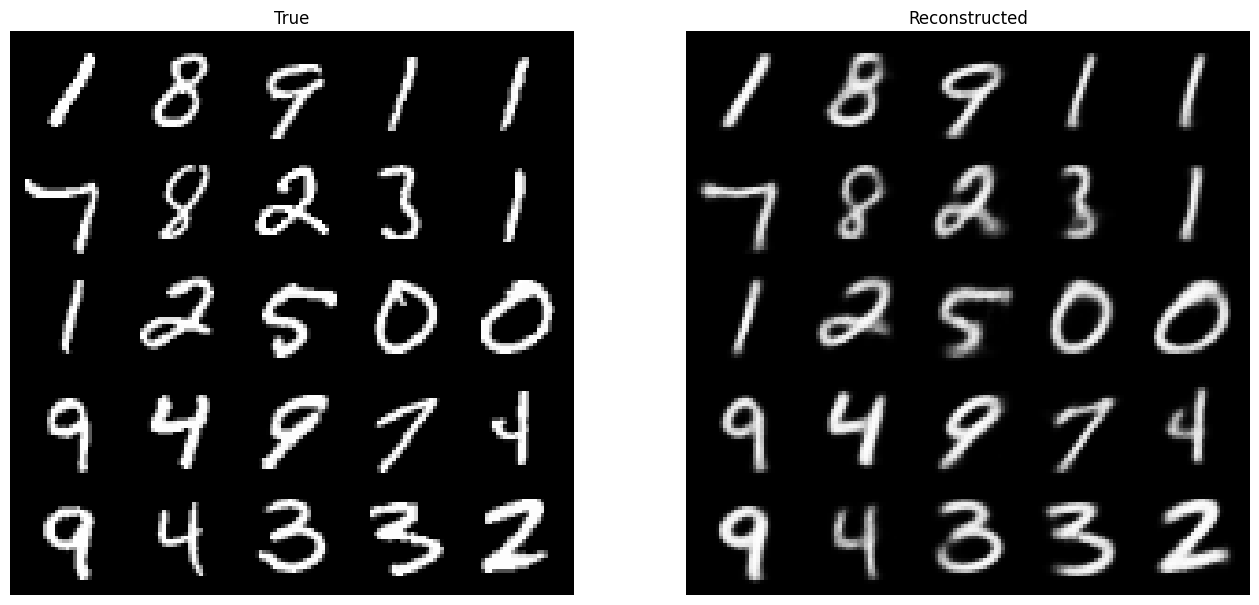

Epoch 46


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.95it/s]


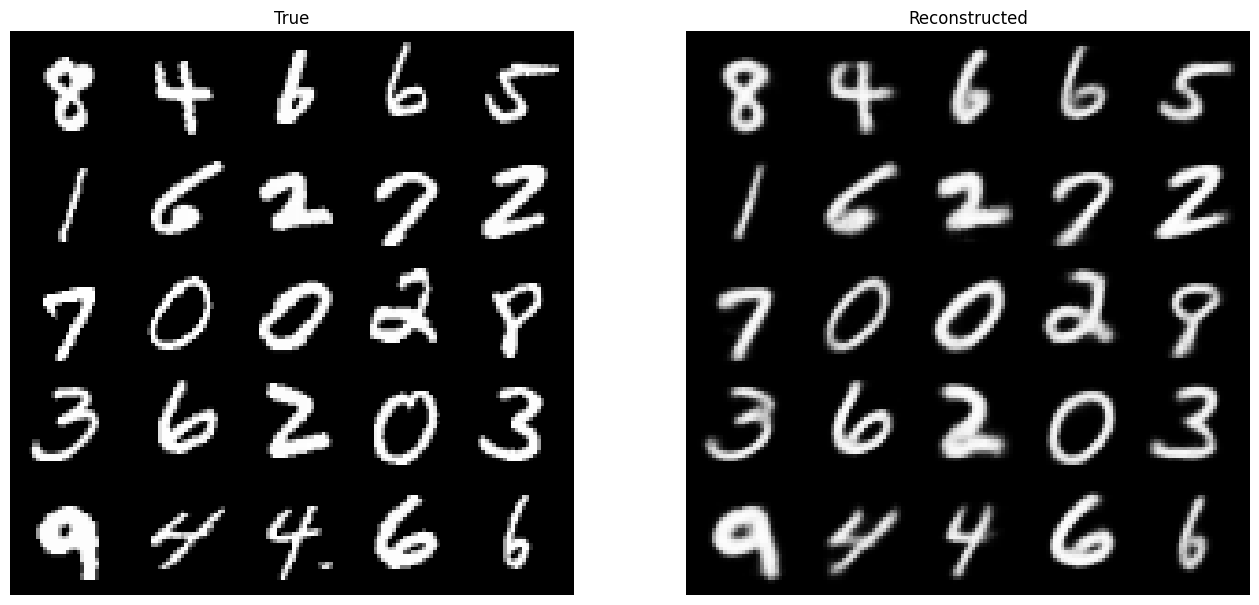

Epoch 47


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.94it/s]


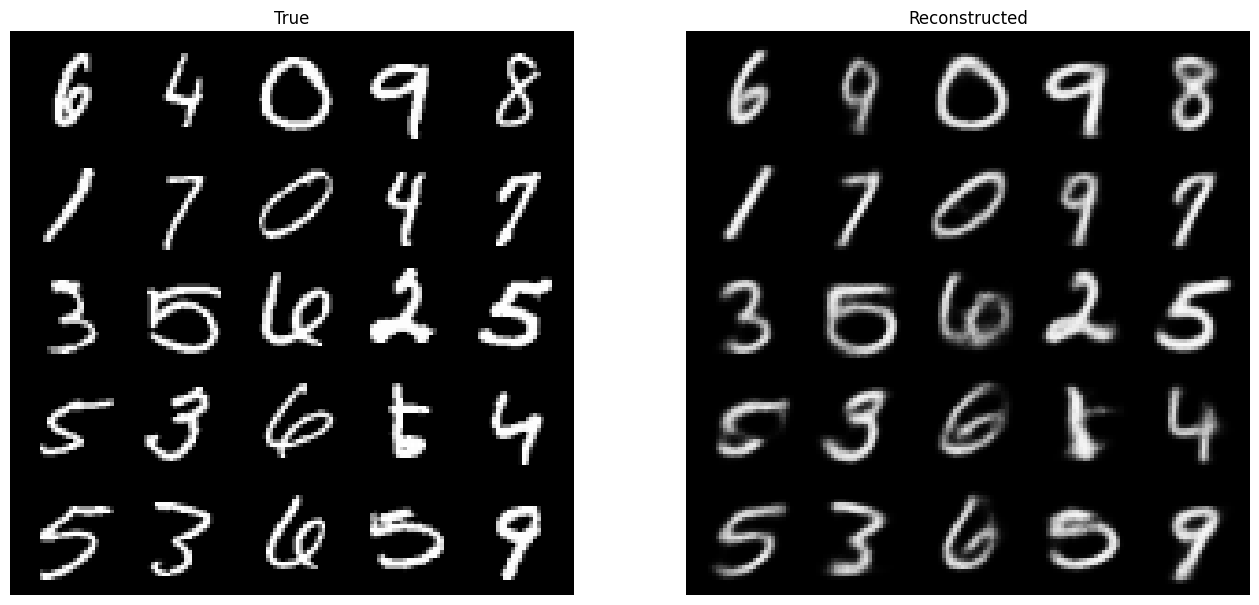

Epoch 48


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.92it/s]


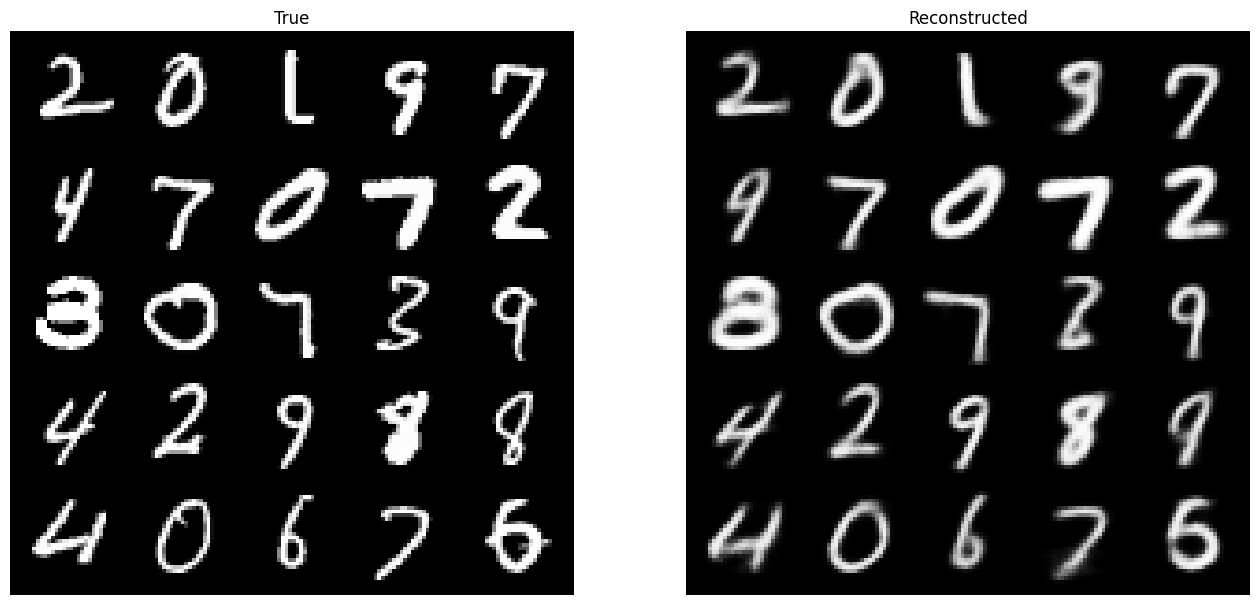

Epoch 49


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:07<00:00,  7.92it/s]


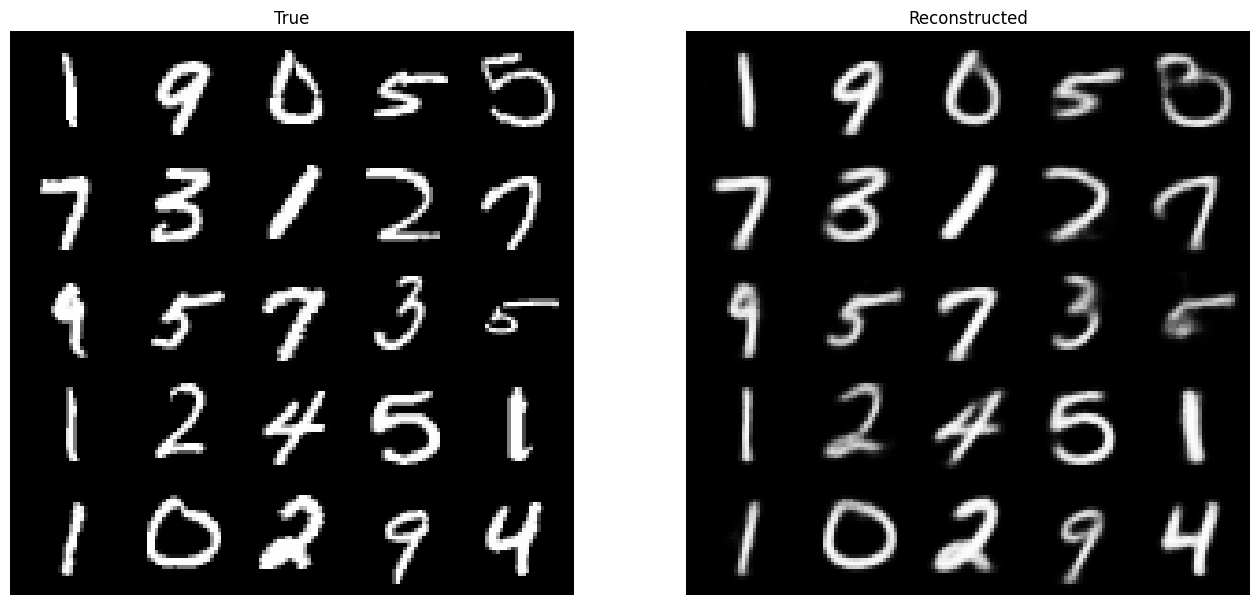

In [32]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 8)

from torchvision.utils import make_grid
from tqdm import tqdm
import time

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.axis('off')
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    
device = 'cuda'
vae = VAE().to(device)
vae_opt = torch.optim.Adam(vae.parameters(), lr=0.002)

for epoch in range(50):
    
    print(f"Epoch {epoch}")
    time.sleep(0.5)
    
    for images, _ in tqdm(train_dataloader):
        
        images = images.to(device)
        vae_opt.zero_grad()
        recon_images, encoding_dist = vae(images)
        loss = reconstruction_loss(recon_images, images) + kl_divergence_loss(encoding_dist).sum()
        loss.backward()
        vae_opt.step()
        
    plt.subplot(1, 2, 1)
    show_tensor_images(images)
    plt.title("True")
    plt.subplot(1, 2, 2)
    show_tensor_images(recon_images)
    plt.title("Reconstructed")
    plt.show()